In [4]:
import cv2
import os
import pytesseract
from langdetect import detect, LangDetectException
from translate import Translator
import nltk
from nltk.corpus import wordnet as wn
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
import matplotlib.pyplot as plt


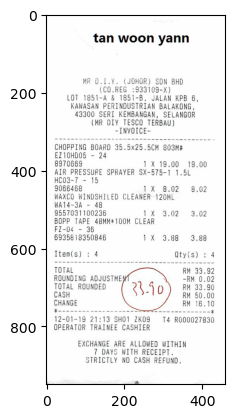

In [5]:
file_name = "./SROIE2019/train/img/X00016469620.jpg"

sample_img = cv2.imread(file_name)
plt.imshow(sample_img)

In [6]:


# Define related words for different categories
clothing_related_words = {'T-shirts', 'Jeans', 'Dresses', 'Shirts', 'Pants', 'Skirts', 'Shorts', 'Jackets', 'Sweaters', 'Hoodies',
                          'Blazers', 'Suits', 'Coats', 'Scarves', 'Hats', 'Gloves', 'Socks', 'Underwear', 'Bras', 'Swimwear',
                          'Activewear', 'Sleepwear', 'Formalwear', 'Workwear', 'Uniforms'}

grocery_related_words = {'groceries', 'supermarket', 'market', 'vegetables', 'fruits', 'meat', 'dairy', 'bread', 'cereal', 'pasta', 'spaghetti',
                         'ghee', 'salt', 'sugar', 'salmon', 'pesto', 'mineral water', 'pastry', 'rice', 'snacks', 'beverage', 'spices',
                         'condiments', 'frozen', 'canned', 'bakery', 'deli', 'almond', 'cheese', 'potato', 'tomato', 'banana', 'beef',
                         'chicken', 'aloevera', 'brood', 'harga jual', 'nestle', 'pesto'}

restaurant_bar_related_words = {'restaurant', 'bar', 'cafe', 'bistro', 'diner', 'pub', 'tavern', 'eatery', 'brewery', 'wine', 'beer', 'cocktails',
                                'donut', 'jamur', 'cappuccino', 'platter', 'service charges', 'hot', 'cold', 'salted', 'roll', 'chicken box',
                                'milk tea', 'donut', 'aumtic annes', 'soup', 'teh tarik', 'appetizers', 'burger', 'biriyani', 'entrees', 'desserts',
                                'beverages', 'menu', 'reservation', 'hostess', 'server', 'chef', 'bartender', 'juice', 'alcohol', 'curry', 'capucino',
                                'tea', 'black sakura', 'mocha', 'coffee', 'juice', 'lemonade', 'KFC', 'matcha', 'ktsu', 'triple cheese', 'lazz', 'niku udon',
                                'crispy', 'spicy'}

utilities_related_words = {'utilities', 'bills', 'electricity', 'water', 'gas', 'internet', 'phone', 'service', 'provider', 'meter', 'service', 'teritaha', 'kitchen',
                           'billing', 'payment', 'usage', 'account', 'customer', 'utility', 'infrastructure', 'maintenance', 'cup', 'plastic', 'plastik', 'adult', 'gift'}

# Function to check if a set of words contains any related words
def contains_related_word(text, related_words):
    text_words = set(text.lower().split())
    return len(text_words.intersection(related_words)) > 0

# Function to extract information from receipt text
def extract_information_from_receipt(text):
    date_match = re.search(r'\d{1,2}[./-]\d{1,2}[./-]\d{2,4}', text)
    date = date_match.group() if date_match else None

    amounts = re.findall(r'\d+\.\d{2}\b', text)
    if amounts:
        floats = [float(amount) for amount in amounts]
        unique = list(dict.fromkeys(floats))
        max_price = max(unique)
    else:
        max_price = None

    # Extract title from the text
    nltk.download('punkt', quiet=True)
    sent_tokens = nltk.sent_tokenize(text)
    title = sent_tokens[0].splitlines()[0] if sent_tokens else None

    return date, max_price, title

# Function to classify receipts based on their content
def classify_receipt(image_paths):
    rows_to_add = []
    for image_path in image_paths:
        print("Processing image:", image_path)
        # Read the image
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Perform OCR using Tesseract
        receipt_text = pytesseract.image_to_string(gray_image)
        print("Extracted text:", receipt_text)
        if len(receipt_text) > 5:  # Adjust the threshold as needed
            try:
                # Detect the language of the text
                language = detect(receipt_text)
                print("Detected language:", language)
                # Check for related words in the text
                is_clothing = contains_related_word(receipt_text, clothing_related_words)
                is_grocery = contains_related_word(receipt_text, grocery_related_words)
                is_restaurant_bar = contains_related_word(receipt_text, restaurant_bar_related_words)
                is_utilities = contains_related_word(receipt_text, utilities_related_words)
 
                # Classify based on the presence of related words
                if is_clothing:
                    category = 'Clothing'
                elif is_grocery:
                    category = 'Grocery'
                elif is_restaurant_bar:
                    category = 'Restaurant/Bar'
                elif is_utilities:
                    category = 'Utilities'
                else:
                    category = 'Others'
 
                # Extract information from the receipt text
                date, total_amount, title = extract_information_from_receipt(receipt_text)
 
                # Add the category and receipt information to the list
                rows_to_add.append({'Category': category, 'Receipt Number': os.path.basename(image_path),
                                    'Text': receipt_text, 'Date': date, 'Title': title, 'Total': total_amount})
 
            except LangDetectException as e:
                print("Language detection error:", e)
                print("Skipping this receipt.")
        else:
            print("Text length is insufficient. Skipping language detection.")
    return rows_to_add

image_dir = "./SROIE2019/train/img/" 
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and not f.endswith('.txt')]
classified_receipts = classify_receipt(image_paths)

df = pd.DataFrame(classified_receipts)

df


Processing image: ./SROIE2019/train/img/X51005442376.jpg
Extracted text: Ao Zi

UNIHAKKA INTERNATIONAL SON BHD
22 Mar 2018 18:24
(887388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustian
‘Tampol,81200 Johor Bahru Johor

TAX INVOICE
Invoice # : OR18032202170428
hem aly Total
‘SR 100100000096- 1 Meat +3 Vege
$7.10 1 $7.40
SR 100100000084-Add Vegetable
$0.50 1 $0.50

Total Amount: $7.60
GST @E%: $0.43
Nett Total: $7.60,

Payment Mode Amount
CASH ‘$7.60
Change $0.00
@stsummay Amouri(s) Tah)
77 04

GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive 01 GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook comBarWangRice

Detected language: en
Processing image: ./SROIE2019/train/img/X51009453804.jpg
Extracted text: 3180303

WAN HING STATIONERY SDN BHD
(162761-M}
NO.32 & 33, JALAN SR 1/9, SEKSYEN 9,
TAMAN SERDANG RAYA,
43300 SERI KEMBANGAN, SELANGOR
DARUL EHSAN
GST ID : 002139201536

Tax Invoice

27032018 No 8.20243

Qty Tax RM

F/Castel! 187087-75 Tack-t 2 SR 12.00


Extracted text: MPH BOOKSTORES
SDN BHD
GST No: 000542572544
MPH One Utama Phase 2
Lot $319, 2nd Floor,
1 Utama Shopping Centre,
Nol, Lebuh Bandar Utama,47800 P.Jaya
Tel:03-77259003 Fax:03-77224003

ee ce a a ee sa se ee te

STICKERS & OTHER GIFT

2312475009906 310.49 31.47 §
Total Amount(incl. GST) 31.47
Rounding -0.02

(| a A

CASH 50.00

CHANGE 18.55

Z - 0% GST 0.00, 0.00
§- 6% GST 29.69 1.78

ITEMS: 3 CASHIER: TRAIN2 TRAINEE STAFF
INVOICE NO: 008558 TRANS: 009628
SHF:i POS:12 O4BFRTL 11/12/2017 21:42:
10
Goods sold are non-returnable
Exchanges may be made for books
only within 7 days from the date of
purchase with this receipt
(Conditions apply)
Thank You for Shopping at
MPH AT ONE UTAMA


Detected language: en
Processing image: ./SROIE2019/train/img/X51005757304.jpg
Extracted text: 1202044

o

#000002 BAIFU (M) Sdn Bhd
COMPANY NO(814198-X)
DAISO JAPAN, IOI MALL
PHONE 03-89763806
GST ID : 001389649920

WELCOME
TAX INVOICE

20/03/2018 7:07pm RCPT NO. 18252
REG:01 CSH:00000008

49976

Extracted text: —_——— —»—

GARDENIA BAKERIES (& )SDN BHD (139386 X)
Lot 3, Jalan Pelabar 23/1,

40300 Shah Alam, Selangor.
Tel: 03- 55423228 Fax:03- 55423213
GST LD: 000381399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 780SF7i2

VEOS14 Gate: 05/88/2017

NAKASSAR FRESH MARKET SDN BHD

GROUND FLOOR, NO. 4 & 6,
JALAN SS 15/4B,
47500 SUBANG JAYA, SELANGOR
Vk0S; Ridzuan( 11900)
DD: 05/08/2017 11:00
Description U.P Iss Iss. “Exe OD “sale ale AmtCRW)

O:C.. WHITE 2.33 3 pH | 4 8.52
WHOL EMEAL 2.78 1 2) Oe 278:
0.c JUMBO 2.97 3 10

Total @& supplies: 11.68

CR-B'SCOTCH 8.72 106 @ © 16 7.20
Total 6% supplies (excl. GST); 7.20
GST: 0.8

Total 6% supplies (Inc, GST): 7.63
Total &% supplies: 11,68

Total Payable: ~ 1931, 31

8.0.6
Keceived above goods in good order condition.
The recipient of Gardenia’s products is
equired to make necessary adjustments to its
tax claims, on the basic of the
itments shown in this Tax Inveice /

ajustment Note lg eeenere |
STOMER'S COPY

ae


Detected language:

Extracted text: of

AEON CO. (M) BHD (126926-H)
SRO FLR, AEON TAMAN MALURI SC
JLN JEJAKA, TAMAN MALURT
CHERAS, 55100 KUALA LUMPUR
GST ID ; 002017394688
SHOPPING HOURS
MON-SUN; 1000 HRS - 2200 HRS

> 000008190901 5.908R
~~ STERILE FILTRAT

Sub-total 5.90
Total Sales Incl GST 5.90
Total After Adj Incl GST 5,90
CASH 10.00
Item Count 1 Change Amt 4.10

Invoice No: 2018020951320023885

GST Summary Amount Tax
SR @ 6% 5.57 0.33
Total 5,57 0,33
09/02/2018 12:53 5132 002 0023885

0301371 NORSHAM BINTI AHAMED SHA

DAISO SUNWAY VELOCITY
TEL 1-300-80-AEQN (2366)
THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGATN

ACE
Gooh Pay Aj ha

Detected language: en
Processing image: ./SROIE2019/train/img/X51006556861.jpg
Extracted text: G ARDE NIA BAKE RIES Sik )SDN BHD (139386 X)
Lot 3, Jalan Pelabur 23/1,
40300 Shah Alam, Selangor.
Vel: 03. 55425228 Fax:03- 55423213
GS'T ED: 000.88 1599040

TAY INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 7908F714

Vv hos i4 Bate: 03/49/2017

HAKASSAR FRESH MARKET SON BHO

GROUND F

Extracted text: (M) SDN BHD

860571-D

LOT 1E51-A & 1851-B, JALAN KP3 6,

KAWASAN PERINUUSTRIAY BALAKONG,
43300 SERT KEMBANGAN, SELANGOR

(6S) 10 No :000305020352)
(TESCO EXTRA ARA DAWANDARA)
TAK INVOLE

WR. OWL.

WA sh BALL=18 #9
Gaul = 12/480

#5

1X 0.19 0.19
_aivds jt 5
TOTAL INCL GST RM 8.11
ROUNDING AQUJUSTMENT ~RM 0.01
TOTAL ROUNDED RM @.10
2M 50.00
XM 47.90

Imnary Amt(RM) = Tax( 2M)

10% 8.11 0.00

‘ee Seance ge

718 12:56 SHOT 1042 Tl RO"0242500
QOERAIUS TADE - ALIM A3DUL

EXCHANGE ARE ALLOW:O WITHIN
’ DAYS WITH RECEIPT. a
STRICTLY NO CASH REFUND. eS

en eee


Detected language: en
Processing image: ./SROIE2019/train/img/X51006392313.jpg
Extracted text: =\ F .

CUPER.SEVEN CASH 6 CARRY SEN SHO 3? (5 = Or
(590150-8)

PAGARAYA BOROHS SUPER SEVEN

KO. 1 Jalan Euro 1

Cff Jalan Batu Tiga

Sungai Bul syen U3 Shah 4lam, 40159
bttps//\ er] com. my

TEL

fAY

CST 70 + 000639090688
TAX INVGICE
YAX INVOICE NG eeeee

CPERATOR + (NG
22-06-2017

KK ABCANG
3556524004265
TERUNG PENDEK 3,15


Extracted text: 4 ‘

x
Ja AN SETIA INTAH
3/X, SETIA ALAN,
4oL70 SHAH ALAM,
83 FAX: G3 ~ 33523608
COOZP4E2B74E

GST NOs

SUPLIFIES Tek LNOICE

i SL DATE: 10/05/2017
2 ANDOZ TINE: 16:22:08

ary U/P AMOUNT

crm) GR
120000143 1 16.00 18.00 §
SCHNEIDER VIVACE 154 S/SOCKET

TOTAL QUANTITY i
SUB-TOTAL (G8T) 16.0
DISC 8.00
ROUNDING 0.00
TOTAL 16.00
GASH 16.00
SHGNGE o.60

RGST @ 6% INCLUDED IN TOTAL

GST SUMMARY

CORE AMOUNT ze

TAX TOTAL: G91

G30DS SOLD ARE NOT RERUNDABLE,
THANE YOU ROR CHOOSING US.
& PROVIDE ORIGINAL BILL FOR GOODS,
SRCHANGE WITHIN 1 WEEK FROM TRANSACTION
GOODS MUST BR IN ORIGINAL STATE TO BE
ENTITLED ROR BRCHANGE.

Rpioy Paes ORO ECE SG SOT LE RO

Detected language: en
Processing image: ./SROIE2019/train/img/X51007339118.jpg
Extracted text: SANYO STATIONERY SHOP
NO. 31G&33G, JALAN SETIA INDAH X ,U13/X
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST ID No: 001531760640

Owned By :
SANYU SUPPLY SDN BHD (1135772-K)

TAX INVOICE

CASH SALES COUNT

Extracted text: MR. D.1.Y. (M) SDN BHD
Co-REG:860671-1
LOT 1851-A & 1851-B, JALAN KPB 4,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No 2000306020352)
(SELAYANG MALL )

-TAX INVOICE-
BISCUIT CONTAINER 10878 8
TES1/3-41/ - 24
8800170 4X 8.90 35.60
12 COLORS GOLD DUST *5
DAI ~ 12/312
9044944 1X 5.90 5.90
HANGER CL45-Y5S x8
RE32-51-71 - 2/24
9064123 2X 7,50 15.00
DENTAL FLOSS 2PCS FHO1-2Y8%)S *S
MG22 - 12/576
9068764 1X 2.50 2.50

SEAL PLASTIC 18PCS B7 13.8CM9.BCMKY ¥§
MHii/2 - 10/240

90683469 1X 2.90 2.90
CURTAIN BAR-70CH x8
Jn32 - 100

90463983 2X 3.10 6.20
Item(s) : 6 Aty(s) : il
TOTAL INCL. GST@4% RM 68.10
CASH RM 100.10
CHANGE RM 32.00

GST 86% included in total RM 3.85
22-04-16 12:01 SHO1 2308 13 ROO0302998
OPERATOR SLC - EALIL ARASI

EXCHANGE ARE ALLOWED WITHIN
3 DAY WITH RECEIPT,
STRICTLY NO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51008042792.jpg
Extracted text: RESTORAN WAN SHENG
; 002043319-W
No.2, Jalan Temenggun

Extracted text: ho4g48
Yo tet ! U f i

AEON CO. (M) BHD (126926-H)
3RD FLR, AEON TAMAN MALURI SC
JLN JEJAKA, TAMAN MALURI
CHERAS, 55100 KUALA LUMPUR
GST ID : 002017394688
SHOPPING HOURS

SUN-THU: 1000 HRS - 2230 HRS
FRI-SAT: 1000 HRS - 2300 HRS
1x 000000417969 4, Q05R
GREEN PEA CHEES
ix 00000041825 3, 905K
BiG NUT BREAD
1x 000600418218 2. 305R
ONION CHEESE
Sub-tota | 10.20
Total Sales Inc] GST 10.20
Total After Adj Incl GST 10.20
CASH 10.20
Item Count 3 Change Amt 0.00
Invoice No: 2018042210100260452
GST Summary Amount Tax
SR @ 6h 962 0,58
Total 9,62 0,58
22/04/2018 19:29 1010 026 0260452
(3304271 PJ NORSYAZWANA

AEON PERMAS: JAYA
TEL 1~300-80-AEON (2366)
THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN

a

Detected language: en
Processing image: ./SROIE2019/train/img/X51005719914.jpg
Extracted text: pei os allie

MR. O.1.¥.(KUCHAT) SON BHD
(CO Reg : 750441-W)
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000473792512)
(TESCO

Extracted text: ea ae ee ee a ee Oe ee eee ee ee

MR. De1.¥. (4) SDN BHD
Co-REG:860671-D

LOT 1851-A & 1851-R, JALAN KPB 4,

KAWASAN PERINDUSTRIAN BALAKONG,

43300 SERI KEMRANGAN, SELANGOR
(GST ID No 2000304020352)

(SELAYANG MALL )
-TAX INVOICE-

BASKET W/HOOK 93144 4S
UF31/3-41/ - 12/144

6934091453268 1X 3.50 3.50
TOILET PAPER HOLDER BWI~2503# KS
W-18 - 24

$944208425037 1X 17.50 17,50
Item(s) : 2 Aty(s) 3 2
TOTAL INCL. GST@46Z RM 21.00
CASH RM 21.00

GST @4% included in total RM 1.19

25-O1-146 11:59 SHO1 2308 13 ROONZ74342
OPERATOR SLC - NOR RUZITA

EXCHANGE ARE ALLOWED WITHIN
3 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND,


Detected language: en
Processing image: ./SROIE2019/train/img/X51006311779.jpg
Extracted text: esate

jes Sewers
ral

= mw

SR GA
i
1

[sess &-Meal us:


Detected language: en
Processing image: ./SROIE2019/train/img/X51006441473.jpg
Extracted text: Tepe iat LOeXL,

y Sdn Bhd

121096057
SUBTOTAL
TOTAL <G8T INCL)
JUSTMENTS 0.02-

ALL exchanges and A eo incl
Guardi

Corrupt JPEG data: bad Huffman code


Extracted text: 0£0 2-2,

AEON CO. (M) BHD (126926-H)
BRD FLR, AEON TAMAN MALURI St
JLN JEJAKA, TAMAN MALURI
CHERAS, 59100 KUALA LUMPUR
GST ID : 002017394688
SHOPPING HOURS
SUN-THU! 1000 HRS ~ 2200 HRS
FRI-SAT #1000 HRS ~ 2300 HRS
HALVED STORER: 1250016708

ak iat OL ee ote I NL ae LG! hth Ne tet! BR Nhe ind Ee LIA DAS Eamets ten?

ix { 600004 921851 P\ 93. g0sR
{0002 TP GIKEN = S)-x"
Aeon card DISC ~4 69
69.21

1x 000006227678 Geb 169.008R
TEFAL CONFORT M IE 2%
Ttem promo @149,00 ~ 20.00
Aeon card OLoC ~{ 45

141.55
1x 000008812854 558 .003R
A1615545 TEFAL

Item promo @259,00 ~299,00
Ago vat DISC ~12.95
246 05
Sub-tota | 476.81
Total Sales Incl GST 476.81
Rounding Adj ~0).01
Total After Adj Incl GST 476 80
CASH 00.00

[tem Count 3 Change Aint 23,20
Invoice No: 2018051110133 130177

GST Suminary Amount Tax
SR @ B% 449 82 26,48
Total 449 62 26.59
11/05/2018 17:19 1013 313 3130177

0304023 Cot NURNABILA EMISHA BINTI
TBRAHIN

REGULAR STAMP(S) + 14
BONUS STAMP(S) 3 0
TOTAL STAMP(S) = 14

A

Extracted text: GARDENIA BAKERIES (KL ) SDN BHD (139386 X)
Lot 3, Jalan Pelabur 23/1,
40300 Shah Alam, Selangor.
Tel: 03- 55423228 Fax:03- 55423213
GST ED: 00038 1399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 7O10F714

Date: 10/10/2017

lassie FRESH MARKET SDN BHD

GROUND FLOOR, NO. 4 & 6,
JALAN SS 15/48,
47508 SUBANG JAYA, SELANGOR

VEOS: Ridzuan (11900)
DD: 10/1 1002017, 12:07

O.€. WHITE é 2.3
WHOLEMEAL 2:78 3 3 t) 0.00
6.C JUMBO 26 9.00

DELICIA-B/SCOTCH 3.72 2 0 2 -7.44

CR-CORN 0.72 a oo 20 4.48

SQ-CHOCMLT 0.84 12 ® @ 12 10.08

TWIG-C. DRM 1233: 8 0 0 8 10.64
Total 6% supplies (excl. GST): 27.68
Gs: 1.65

Total 6% supplies (Inc. GST): 29.33
Total Q% supplies: — -2.3

Total Payable: 27.20

E.&.0.E.
Received above goods in good order condition.
The recipient of Gardenia's products 1s
required to make necessary adjustments to its
input tax claims, on the basic of the
adjustments shown in this Tax Invoice /
Adjustinent Note

CUSTOMER'S COPY

hae Pace.

Detected language: en
Pr

Extracted text: eee

'

' TAX INVOICE

BHPetro} Subang Airport
Jalan Lapangan Terbang Subang
47200 Subang
Selangor _
D'Rosh Servport
CO. REG. NO; 000948487-V
GST REG, NO: 000768122880

18-01-2018 15:44:46 Cashier: 888
invoice No: 1-916166

Item U\Price Qnty Amount

TOTAL AMOUNT PAYABLE
RN 41.95%

EDC MASTER RM 41.95

EST SUMMARY Amount RM Tax RM
5: Standard 6% 39.58 2.37%
ECARD
WONG TAI CHIN
Card Number 7897 13901 1585960
Hershant Number 00000+926 138423
Reference Nunber 199258579655
AWARD Balance 412
Earned 4]
New Balance 453
EPOINTS Expiry 24 31/10/2020

136 30/11/2020

Thank You For Shopping At 2Petromart
Customer Service 1-3G0-22-2828

Detected language: en
Processing image: ./SROIE2019/train/img/X51008142032.jpg
Extracted text: ONE GONE THREE SEAFOOD RESTAURANT SDN BHD
(1120908-M)

NU.1, .AMAN SRI DENGKIL, JALAN AIR HITAM
43800 DENGKIL, SELANGOR.
(GST Reg. No : 000670224384)
Tax Invoice

Table O3

Bills :¥001--539233 Order#: 139336
Date +; 28-05-2018 23:28:57

baenter: 113 wadiaai

Extracted text: K0s0 3z

UNIHAKKA INTERNATIONAL SDN BHD
14 May 2018 18:10

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR180514021 70467
Item Qty Total
SR 100100000035- 1 Meat + 3 Vege
$7.10 1 $7.10
SR 100100000065-Add Meats
$0.90 2 $1.80

Total Amount: $8.90
GST @6%: $0.50
Nett Total: $8.90

Payment Mode Amount

ee

CASH $8.90

Change $0.00

GST Summary Amouni($) Tax($)

SR = GST @6% 8.40 0.50
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/train/img/X51006913030.jpg
Extracted text: ws. AO
fa |

i. ri 4
OV INET Fe
| OSG28

UNIHAKKA INTERNATIONAL SDN BHD
10 May 2018 12:32

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor
TAX INVOICE
Invoice # : OR18051002160062

Item Qty Total
SR 100100000060- 4 Vege ~

$5.50 { $5.50
SR 10010

Extracted text: t

-ealive

CT281 - Tealive Shell Kepong
Ottogo Enterprise

002570632-X

GST 1D:001018802176
SHELL STATION PT15944, Mukim
Batu,
Jin Besar Kepong

TAX INVOICE
Counter: 7290 Take Away
Bill No: 394024495 COMPLETED
Date: 21/01/2018 15.4609
Sales Remarks.

ItemName ty Price(RM)

Hazelnut Coco -L 1 750 SR
‘Pearl 1 1.10

Sub Total = RM8.60.
Rounding  RMO.00

Total Sales Incl GST @ 6% RM8 60

Cash 8.60

Tendered 9.00

Change 0.40
Code Amount Tax
SR @ 6% 8.12 0.48

You have just missed out 8 points
Sign up for a Tealive UniTea Card
today to enjoy exclusive member
promotions and collect BPoints to
redeem on future purchases

Thank You Please Come Again
Printed at:21/01/2018 15:46:09


Detected language: en
Processing image: ./SROIE2019/train/img/X51007339136.jpg
Extracted text: SANYO STATIONERY SHOP

NO. 31G&33G, JALAN SETIA INDAH X ,U13/x
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137
GST ID No: 001531760640

: TAX INVOICE
Owned By :
SANYU SUPPLY SDN B

Extracted text: MR. 0.1. ’. (M) SON BHD
Co-REi:360671-D
LOT 1851-A & 1351-B, JALAN KPB 6,
KAWASAN PERINJUSTRIAN BALAKONG,
43400 SERI K°MBANGAN, SELANGOR
(GST 19 No :000306020352)
(TESCO EXTR\ ARA DAMANSARA}
| ~TAX INVOICE-
PILLAR SINK TAP +8
F102 - 8/54

9072351 2X 23.90 47.80

SHIE!DTOX FIK 500 4L MP *§
HAUT - 24

9556111988559 1X 8.90 8.90

SPONGE KOREA-25 *§

 ARG2 - 12/312

9064017 4X FT 00 T2- 00
PLASTIC BAGS *S
99999 Torneo. 20 = 0.20
VANCE LIGHTER -Is VT02 *S

WB22 - 50/100°
9655258506 166 5X 0.60 3.00
Item(s) : 5 Qty(s) : 13
TOTAL INCL. GST@6% RM 71.90
CASH Shh 72.00
CHANGE RM 0.10
GST Summary Ant(RM) Tax(RM)
GST S@6! 67.33 4.07

it — aids be eh ee A ER a fo F
02-03-18 S23 SHIT 2J42 = 71 ROOO227410
OPERATOR TADC - AIM ABDUL

EXCHANGE AR: ALLOWED WITHIN

/ DAf W.TH RECEIPT.
STRICT.¥ WO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51005605335.jpg
Extracted text: POPULAR BOOK
CO. (M) SDN BHD

(Co. No. 113825-W)
2000)

(GST Rew No. 0014929

No 8, Ja

Extracted text: ay

POPULAR BOOK

CO. (M) SDN

(Co. No. 113825-W)

BHD

(GST Reg No. 001492992000)
No 8, Jalan 7/118B, Desa Tun Razak
56000 Kuala Lumpur, Malaysia

SUNWAY VELOCITY

Tel : 03-9201 6281/6920

29/03/18 13:24 Slip No.: 0010111111

WONG HUI LING Trans:

121722

PB SHT/P 11H A4 10'S C€/0.
2pe @ 3,50
R RING 500'°S

Total RM Incl. of GST
Cash
CHANGE

Item Count
GST Summary Amount (RM)
T @ 6% 9.10

0.55

BE A POPULAR CARD MEMBER
AND ENJOY SPECIAL DISCOUNTS
THANK YOU. PLEASE COME AGAIN.

www. popular. com. my
Buy Chinese books online
www. popularon| ine. com. ny


Detected language: en
Processing image: ./SROIE2019/train/img/X51005365179.jpg
Extracted text: 3-1707067

(481500-M)
CW KHOO HARDWARE SDN BHD
NO.50 , JALAN PBS 14/11,
KAWASAN PERINDUSTRIAN BUKIT SERDANG,
Tel : 03-89410243 Fax : 03-89410243
GST Reg No. : 000549584896

Tax Invoice

Invoice No. —: CR 1803/0064

Date : 01-03-18 5:23:26 PM
Cashier No. —: khoo
Counter No, ‘cl
Printed Date : 01-03-18 5:23:30 PM

5 Item(s) Tota

Extracted text: Rodos

UNIHAKKA INTERNATIONAL SDN BHD
09 Apr 2018 18:26

(867388-U)
42, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru,Johor
TAX INVOICE
Invoice # : OR18040902160299

Item Qty Total

SR 100100000060- 4 Vege

$5.50 1 $5.50
SR 100100000006- Pork
$2.70 1 $2.70

Total Amount: $8.20
GST @6%: $0.46
Nett Total: $8.20

Payment Mode Amount

CASH $8.20

Change $0.00

GST Summary Arnount($) Tax($)

SR = GST @6% 7.74 0.46
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/train/img/X51006557213.jpg
Extracted text: Tel

: 03-

=RIES (KL) SDN BED (139386 X)
Lot 3, Jalan Pelabur 23/1,

40300 Shah Alam, Selangor.

§423228 Fax:03- 55423213

GST LD: 000381399040

TAX INVOICE / ADJUSTMENT NOTE

V E0514

Cash Inv No.: 7001F710

Date: 01/10/2017

MAKASSAR FRESH MARKET SON BHD

GROUND FLOOR, NO. 4 & 6,
JALAN SS 15/46,



Extracted text: SANYO STATIONERY SHOP

NO. 31G&33G, JALAN SETIA INDAH X ,U13/X
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937
Tel: +603-3362 4137
GST ID No: 001531760640

: TAX INVOICE
Owned By :
SANYU SUPPLY SDN BHD (1135772-K)
CASH SALES COUNTER
“17002-0014 SONOFAX - EC THERMAL ROLL
(BLUE) - (S7MMx60MMy12MM)
(1OROLL/PKT)
1X 35.0000 : 35.00 SR
Total Sales Inclusive GST @6% 35.00
Discount 0.00
Total 35.00
Round Adj 0.00
Final Total ~—~—~—=«235.00
CASH 50.00
CHANGE 15.00
‘6st Summary. Amount(RM).—SSsTax(RM)
SR @ 6% 33.02 1.98

INV NO: CS-SA-0097366 Date: 18/07/2017

Goods sold are not Returnable & Refundable

THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN.

TERIMA KASIH SiLA DATANG LAGI

** PLEASE KEEP THIS RECEIPT FOR PROVE OF |
PURCHASE DATE FOR I.T PRODUCT WARRANTY
PURPOSE **

Follow usin Facebook : Sanyu.Stationery


Detected language: en
Processing image: ./SROIE2019/train/img/X51005685355.jpg
Extracted text: 3180301

RESTORAN IBRAHIM MAJU SB
NO.2, GROUND FLOOR, JALAN REKO SE

Extracted text: Golden Arches Restaurants Sdn Bhd 7
(65351-M)

Level 6, Bangunan TH, Damansara Uptown3
No.3, Jalan $$21/39,47400 Petaling Jaya
Selangor
(GST ID No: 000504664064)
McDonald's MRR2 Kepong DT(#251)

Tel No. 03-6259-6498
TAX INVOICE

MFY Side 1

INV# 002511900048269
ORD #95 -REG #19- 24/07/2016 14:21:51

QTY ITEM TOTAL
2 VM McChicken 15.90

2 M Coke

2 M Fries
1 McChicken 4.00
2 SundaeChoc 6.40
1 ChocTop 1.90
TakeOut Total (incl GST) 28.20
Total Rounded 28.20
Cash Tendered 100.00
Change 71.80
TOTAL INCLUDES 6% GST 1.60

Thank You and Please Come Again.
Customer Service Hotline : (3-2726-5600

a A


Detected language: en
Processing image: ./SROIE2019/train/img/X51005568884.jpg
Extracted text: MR. D.I.Y. SDN BHD
(CO.REG :704427-1T )
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(G51 ID No :001092886528)
(CHERAS LEISURE MALL)

TAX INVOICE-
BATTERY .hU3-4B AAA 4 PCS *§
XC12 - 12/144
9021937 1X 3.90 3,90
Item(s) : 1 Qty(s) : 1
To

Extracted text: RESTORAN WAN SHENG
(102043319--W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO: 001335787520

Tax Invoice

INV No.: 1219461 Cashier: Thandar
Date +: 30-06-2018 22:16:06

Description Qty 4. price Total TAX

1x 2.10 2.10 ZRL

Soya Bean

1x 2,10 2.10 ZRL
Tota] ary: 2
Total (Excluding GST): 4.20
Total (Inclusive of GST): 4,20
TOTAL: 4.20
CASH ; 4.20
GST Samry Amount(RM) — Tax(RM)
ZRL (@ 0%) 4,20 0.00


Detected language: en
Processing image: ./SROIE2019/train/img/X51005303661.jpg
Extracted text: LIGHTROOM GALLERY SDN BHD
No: 28, JALAN ASTANA 1C
BANDAR BUKTT RAJA, 41050

KLANG SELANGOR D.E, MALAYSIA
ROC No. : (1072825-A)
_ GST No. : 000584089600
Tel :03-3362 4395 Fax: 03-3362 4395

: TAX INVOICE
Station: CASHIER Bill No: LCS03908
Cas r: ANGELA Cover ;: |]
Bill Date ; 20/12/2017
Bill Start: 20/12/2017 07:10:35 PM

Code : 300-C0001

Name : CASH

Address

GST No.

CH50514 SR

T5 JOINT 2PIN 2PcS

1 * RM 2.83 UNI ( 0. 17)=RM 2. 8

Extracted text: AMTECH ELECTRICAL SUPPLIES
(001963477-M)
(GST '!D No 001285423104)
107, JALAN BANDAR RAWANG 2
PUSAT BANDAR RAWANG,
48000 RAWANG, SELANGOR D E
email: anitech8B6@yahoo com

lelFax 09 009 Hire

Tax Invoice
Bill No POS/27408
Date 27/06/18 50232 PM

Cashier amit
Payment = Cash

Item Qty Price Amount
30W SUPER T8 LED TUBE*D/L -FNM @16.00
00004285 5 16.00 80.00 SR
2x40W LED F/FITTING (EMPTY)-ITK @14.00
00002348 4 14.00 56.00 SR
Gross Amt 136.00
GST (6%) 0.00
Net Amt: 136.00
Received 150.00
Change 14.00
Round Adj 0.00
GST Summary  Amount(RM)  Tax(RM)
SR @ 0% 136.00 000

THANK YOU
i - PLEASE COME AGAIN

Detected language: en
Processing image: ./SROIE2019/train/img/X51005453804.jpg
Extracted text: 3180303

WAN HING STATIONERY SDN BHD
(162761-M}
NO.32 & 33, JALAN SR 1/9, SEKSYEN 9,
TAMAN SERDANG RAYA,
43300 SERI KEMBANGAN, SELANGOR
DARUL EHSAN
GST ID : 002139201536

Tax Invoice

27032018 No 8.20243

Qty Tax RM

F/Castel! 187087-75 Tack-t 2 SR 12.00
75g- White (new) @ 5.6600

Total

Extracted text: RESTORAN WAN SHENG
002043319-W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO; 001335787520

Tax Invoice

INV No.: 1047523 Cashier: Thandar
Date : 16-03-2018 12:07:10

Kopi (B)
X 2.20 2.20 SR

Teh (B)

1x 2,20 2.20 SR
Cham (B)

2 x 2.20 4.40 SR
Take Away

4 x 0,20 0.80 SR
Total QTY: 8
Total (Excluding GST): 9.07
GST payable (6%): 0.53
Total (Inclusive of GST): 9,60
TOTAL: 9.60
CASH ; 9,60

GST Summary Amount(RM) — Tax(RM)
SR (@ 6%) 9,07 0,53


Detected language: en
Processing image: ./SROIE2019/train/img/X51005711456.jpg
Extracted text: SUSHI MENTAI - MAHKOTA CHERAS
MIZU MENTAI SDN. BHD. (1248446-V)
NO: 1~1&2 GROUND FLOOR,
JLN TEMENGGUNG 13/9,
43200 CHERAS SELANGOR.
(GST Reg. No ; 001375580160)

Tax Invoice

Table 9

Order#: 114105

Bill#: V042~ 513777 Pax(s): 0
Date +: 31-03-2018 18:12:41
Cashier: SOFYA

Bi Green Tea

N8 Shiro Ramen

1x 12.80 12.80 SR
R9 Unagi Don

1x 19.80 19,80 SR
F8 Tori Karaage

1x
§B01 Sushi Yellow

Extracted text: LEE WAH FLORIS) y SDN BHD

(G212
129, JALAN a ‘i S LEE,
§0000 KUALA LUMPUR,

TEL 03-20782322 /012-5389466 FAX 03-
SALES@|EEWAHFLORIST.COM
GST ID : 00101 1499008

TAX INVOICE

Doc No > CS00183546 Date: 92/02/2018
Cashier : USER Time 21:41:00
Salesperson Ref.:
(GST) (GST)
tem Oly, S/Prive S/Prica _Arnount Ta:
1015 2 1200 137% lied SR
PEACOCK YELLOW
1012 4 34.00 AG O4 144.16 SR
STATICE FULL IMP
1145 1 $8.60 61.48 61.68 SR
LiL'’ CONCORDO 2H
1037 2 6.c0 €.36 12.72 ER
SNOW WHITE LEAF
4050. 1 3600 3.71 B71 SR
FLORIDA BEAUTY
1097 4 9.00 6.54 38.76 SR
PALM LEAF L
1098 3 4.50 4.77 14.31 &R
PALM LEAF M
1006 { 22.00 24.32 24.32 SR
ROSE INDIA SUPERICR
2748 4 12.00 12.72 50.88 SR
SUGCULENT L een
Sa TollGyi an) aot USE
Total Sales \Exclucing GST) . 353.00
Discount ° 0.00
Total GST : 21.18
Rounding 0.02

Total Sales (Inclusive of GST) : 374.20

CASH : 400.00
Change : 25.80

TGSTSUMMARY =———“‘“‘ U;é‘(a(‘CéC;C;!C
Tax Code % Ami(RM) Tax (RM)!
SR is) 353.06 21.18;
EUS SO

GOODS SOLD ARE NO

Extracted text: #)

SLF CASH & CARRY
NO.15,JLN 1532, THN SURANG JASA,
OFF JLN BY 3 SUBANG,

40000 SHAH ALAM, SEL’

GST NOs 001149342944
TEL: 03-77343462 FAX: TAX INVOICE

RECEIPT #: (900241867 DATE: 02/02/2018
SALESPERSON : TIME: 08:31:00
CASHIER : KELLY

6194020100124 4 11.32 945.28 §
(UNIT) ROYAL BAKING POWDER 4506

TOTAL QUANTITY 4

SUB-TOTAL 45.28
DISC 0.00
TAX 0.90
ROUNDING 9.00
TOTAL 42.004
CASH 48_o6
CHANGE L o-oo
GOODS SOLD ARE NOT RETURNABLE,
THANK YOU,

iy

Detected language: en
Processing image: ./SROIE2019/train/img/X51005255805.jpg
Extracted text: SAM SAM TRADING CO
(742014-W)
67,JLN MEWAH 25/63 THN SRI MUDA,
40400 SHAH ALAM.
TEL/FAX : 03-51213881
BST NO: 001006288896

TAX INVOICE

HE EOG UNICORN TWIN SUPER GLUE USG-99-
9997368063013 1X $.20 5.20 §

55 EZL A4 CYBER MIX COLOR PAPER 100758

2979008 1X 8.90 8.90 S
No. Qtyss 2 No. Items: 2
TAX AMT {S) 6% Ri 13.30
GST 42 RM 0.80
TAX AMT (Z) 0% RM 0.00
GST 0% RM 0.00
TAX ANT (E) 62 RH 0.00
EXC GST 62 RM 0.00
TOTAL RM 14.10
CASH 

Extracted text: MR. DeI.¥. (KUCHAT) SDN BHD
(CO Reg : 750441-W)
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000473792512)

(KEPONG)

-TAX INVOICE-
STEEL WOOL SH-2# *§
EZ03 - 12/144
8970273 5X 1.79 8.95
Item(s) : 1 Qty(s) : 5
Tota] Incl. GST RM 8.95
CASH RM 50.00
CHANGE RM 41.05
GST Summary Amt(RM) = Tax(RM)
GST SR@0% 8.95 0.0

15-06-18 17:12 SHO2 B003 12 000851481
OPERATOR KPOT - SHAHRUL NIZAM

EXCHANGE ARE ALLOWED WITHIN
7 DAYS WITH RECEIPT.
STRICTLY NO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51006882603.jpg
Extracted text: TAX INVOICE
Eco-Shop Marketing Sdn Bhd
"GST Reg. No : 000313901056
Company No: 734055-M
Lot F1-01, 6, Jalan 8/27A,
Seksyen 5 Wangsa Maju,
53300 Kuala Lumpur,
Wilayah Persekutuan Kuala
Lumpur, Malaysia.
INV No # : BWMCO200004 7293
26/02/2018 17:31
CS : ROSSYAFIQAH ANIS BINTI
RAMLI [BWM0034|
STK QTy RM
JT5501 - CHOPSTICK HOLDER

72/1

65045039@2. 33 1 2.33
PLIERS 6"

Extracted text: 107

Gerbang Alaf Restaurants Sdn Bhd
(65351~M)
formerly known as
Golden Arches Restaurants Sdn Bhd
Licensee of McDonald’s
Level 6, Bangunan TH, Damansara Ustown
No.3, Jalan $821/39,47400 Petaling Java
Sethangor
(GST ID No: 000504664064)
McDonald’s Shel] Mahkota Cheras DY (#36
Tel No. 03-9010-9849
TAX INVOICE

MFY Side 1

INV# 002621900059183
ORD #07 -REG #19- 10/03/2018 17:24:07

QTY ITEM TOTAL

1M Coke 3.50

1 McChicken 5.00
TakeOut Total (incl GST) 8.50
Total Rounded 8.50
Cash Tendered 50.00
Change 41,50
TOTAL INCLUDES 6% GST 0.48

Thank You and Please Come Again.


Detected language: en
Processing image: ./SROIE2019/train/img/X51006619563.jpg
Extracted text: 99 SPEED MART 5/B (519S37-X)
LOT P.7. 2811, JALAN ANGSA,
TAMAN BERKELEY
41150 KLANG, SELANGOR
1558-TMN PUSAT KEPONG
GST ID. NO : 006181747712

INVOICE NO : 17858/102/T0308

O73 S4P4 561781 21-11-16
5384 STAR BRAND GARBAGE BAG RM31.80 ¢
@6 X RM 5.30
Total Sales (Inclusive 6ST) RM 31.80
CASH RM = $0.00
CHANGE RN =

Extracted text: RESTORAN WAN SHENG
02043319-W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO: 001335787520

Tax Invoice

INV No.: 1085405 Cashier: Thandar
Nate +; 09-04-2018 13:16:21
Description Qty  U.price Total TAX
Teh (B)
1x 2.20 2.20 SR

Cham (B) ;
1x 2,20 2.20 SR
Herbal Tea
2x 1,70 3.40 SR
Take Away
4x 0.20 0.80 SR
Total Qly: 8
Jotal (Excluding GST): 8.11
GST payable (6%): 0.49
Total (Inclusive of GST); 8.60
TOWA: 8.60
COCRSH 8,60
GS) Summary Amount(RM} — Tax(RM)
SR (@ 6%) 8.11 0.49

»

Detected language: en
Processing image: ./SROIE2019/train/img/X51006913051.jpg
Extracted text: pate,

7 ee
ae coat

ay .

THE TOAST F&B SDN BHD ($65752-1)
LOT 211082111 JALAN PERMAS UTARA
BANDAR BARU PERMAS
81750 JOHOR BAHRU JOHOR
Tel: 07-388682
GST ID No 002069884028

TAX INVOICE

5eadig0saea5 ——~S*«w 1/08/2018
S/F: POS Loc: PMS
Waik In
Table:| oT
tem Qty ‘U.Price Dise = Amount
711 WM TUNA
4 Boo 0.00 5008
2124 CANTONESE _
| 40.00 0.00 10.00 5
220.

Extracted text: L
LO
TA

ee ates mene

AVENDER CONFECTIONERY & BAKERY S/B
COMPANY NO: 499702-V
T G29 & G30, AEON Mall TEBRAU CITY,
NO, 1, JALAN DESA TEBRAU,
MAN DESA TEBRAU, 81100 JOHOR BARRU.
TEL : 07-364 3785
GST ID NO: 001872379904
TAX INVOICE

pestis eta 4 Ate dl gL Wn cat Ma 1 OE Sm La MERE SO HOLY Sry SONY et, MOON SM Leh ws WRN A SAS “NT AA i MY RS STEREO ED ect MA

14/04/2018 16:14 BS99215
Qty Descriptions Amount
1 EUROPEAN WALNUT 6.50 T
1 ORANGE PEEL CHOCOLATE 5.80 7
TOTAL 12.30
CASH | 20,00
CHANGE ¢.fO0
Incl. 6% GST 0.70
PRICES INCLUSIVE 6X GST
GST Summary Amount Tax
Ts GST 11,60 0.70
Z: Zero Rated 0,00 0,00
Sign; — __

Gsh
POs

www, lavender .com. my
THANK YOU,

, All sales are final. Goods sold

are not refundable nor exchangeable.

. Our products contain no added

preservatives, please consume within
a day or keep according to
recommendations on packaging.

. For feedback, please retain this

Tax Invoice, Seek store manager
assistance OR drop us an email.

. Tax Invoice ca

Extracted text: 3 '¥ Ol Olt

SYARIKAT PERNIAGAAN GIN KEE
(81109-A)
NO 290, JALAN AIR PANAS,
SETAPAK,
63200, KUALA LUMPUR.
TEL : 03-40210276
GST ID : 000750673920
SIMPLIFIED TAX INVOICE

CASH
‘Doc No ~ CS00012664 Date: 11/01/2018
Cashier > USER Time: 11:42:00
Salesperson - Ref. .
Item ss Qty, —S/Price ~=Amount Tax
1627 1 4.45 4.45 SR
WALL SCRAPER 3"
2167 2 50.88 101.76 SR
4.5KG RENDEROC PLUG
1735 10.07 1007 SR
5" SCRAPER (ADAMARK)
Total Qty 4 ~ 1628000
Total Sales (Excluding GST) 109.70
Discount . 0.00
Total GST 6.58
Rounding - 0.00
Total Sales (Inclusive of GST) : 116.28
CASH : 116.28
Change : 0.00
‘GST SUMMARY . - -
Tax Code % Amt (RM) Tax (RM)
SR 6 109.70 6.58

Total : 109.70 6.58,

GOODS SOLD ARE NOT RETURNABLE, THANK YOU

a


Detected language: en
Processing image: ./SROIE2019/train/img/X51007846350.jpg
Extracted text: AO6 ASO

PASARAYA CINWA SDN BHD
(1113440A)

NO,6, 8, 10& 12 JALAN PERMAS 4/3
BANDAR BARU PERMAS JAYA,
81750 JOHOR BAHRU, JOHOR,

TEL : 07-3881722 FAX : 07-3873971
GS

Extracted text: cs

SANYO STATIONERY SHOP
NO. 31G&33G, JALAN SETIA INDAH X ,U13/X
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

come ID es 001531760640 TAX INVOICE
wned By:

SANYU SUPPLY SDN BHD (1135772-K)

CASH SALES COUNTER
“15002-0080 WIRE 0 (3:1) DOUBLE WIRE AS
34 LOOPS - 6.4MM (WHITE)
6 X 4.0000 - 24.00 SR
2. 5002-0004 PVC- RIGID SHEET BINDING CC
a4
12 X 0.8000 - 9.60 SR

Discount

Total

Round Adj

Final Total

CASH 50.00

CHANGE 16.40
GST Summary Amount(RM)———Tax(RM)
SR @ 6% 31.70 1.90

INV NO: CS-SA-0127449
Date: 29/11/2017
Total Qty: 18

Print Time : Wednesday, 29 November, 2017 4:18:55

Goods sold are not Returnable & Refundable

THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN.

TERIMA KASIH SILA DATANG LAGI

** PLEASE KEEP THIS RECEIPT FOR PROVE OF
PURCHASE DATE FOR I.T PRODUCT WARRANTY
PURPOSE **

Follow us in Facebook : Sanyu.Stationery~


Detected language: en
Processing image: ./SROIE2019/train/img/X51006619343.jpg
Extracted text: MR. D.1.¥. 

Extracted text: . R

KEDAI PAPAN YEW CHUAN
(0005583085-K)

LOT 276 JALAN BANTING
43800 DENGKIL, SELANGOR.

TEL : 03-87686092 FAX : 03-87686092
GST ID : 000781500416

TAX INVOICE

Bill To

SUC] ALAM JAYA TRANSPORT

NO 1 JALAN AMAN 2

TAMAN DESA 43800

DENGKIL SELANGOR

017-6057770

DocNo.  : CS000T7357 “Date: 31/03/2078

Cashier ’ USER Time: 09:29:00
Salesperson - Ref.:
(GST) (GST)
Item Qty _S/Price S/Price = Amount i
101756 10 16.50 17.49 174.90
SIMEN
~ Totaly: i060 — 474,90 c-
Total Sales (Excluding GST) : 165.00
Discount : 0.00
TotalGST : 9.90
Rounding : 0.00

Total Sales (inclusive of GST) : 174.90

CASH : 174.90
q Change : 0.00

GST SUMMARY —

165.00
165.00


Detected language: en
Processing image: ./SROIE2019/train/img/X51008142063.jpg
Extracted text: KEDAI PAPAN YEW CHUAN

(0005583085-K)

LOT 276 JALAN BANTING

43800 DENGKIL, SELANGOR

TEL : 03-87686092 FAX

_TAX INVOICE

Bill To :

SUCI ALAM JAYA TRANSPORT
NO 1 JALAN AMAN 2

TAMAN DESA 43800

03-87686092
GST ID : 000781500416

D

Extracted text: eS

: .

WR. D.1.Y. (KUCHAT) SDN BHD
LOT i85i-A & 1851-B, JALAN KPR 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR

(GST ID No 2000473792512)

(56 WANG)
SPONGE DISHES 4103# *§
WHI4-21-52 - 12/120
9068739 1X 3530 ~ 3.80
Item(s) : 1 Oty(s) 4
Total Incl. GST@4% RM 3.30
CASH RM 3.30

GST @6% included in total RM 0.19
17-04-16 14:02 SHO1 BO19 = 13 ROOO034325
OPERATOR CHC - JIVAN

EXCHANGE ARE ALLOWED WITHIN
3 DAY WITH RECEIFT.
STRICTLY NO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51007339158.jpg
Extracted text: SANYO STATIONERY SHOP
NO. 31G&33G, JALAN SETIA INDAH X ,U13/X
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST I 531760640
pp TAX INVOICE
Owned By :
SANYU SUPPLY SDN BHD (1135772-K)
CASH SALES COUNTER
“1, 5000-0001 PHOTOCOPY SERVICES -Ad
SIZE
50 X 0.1000 SR
Total Sales Inclusive GST @6% “
Discount
Total
Round Adj
Final Total
CASH 100.00
CHANGE 95.00
GST Summary Amount(RM) Tax(RM)
SR @

Extracted text: TAX INVOICE
DOMINO'S PIaza
GST REF NO : 001694261248
DOMINO'S PIZZA TAMAN UNIVERSITI
30, Jln Kebudayaan 7, Tmn Universiti
81300 Skudai, Johor

CARRY OUT HOW Pay By: CASH

Order : LLL Ry :WEB 30503
Orcler Time : 10:52:09 Bate -08/05/18

Name: HS JOAN WONG
Pickup Time: 11:07:09

Qty Menu Desc Coupen Disa Price
L 6"HT (KB) | WIUELA-E 15.60
8.90 15.60

Total Items

Sub-Total : 15.60
Couron Discount 4 * 8.50
Grand Tota. : 6.70
Payment : 50.06
Change Due : 43.30
*6% GST Included : 0.38

SUPPORT OUR SMILE CAMPAIGH : }
Did we smile at you?
Let us know at
waw. dominos.com.my/smila and
receive a 30% off side item @e-coupon
upon survey submission
Survey Code: WREO80740082052
Thank you for vasiving Domino's.
Please Come Again!
1-300-888-3358
wrw .dominos .com. my

We are compliant to the PDPA “UiL.
Visit www.dominos.. ‘.my/terms
to view cur Personal Data

Protection «cs. -

~e

Owe = a by
Dommal Food 38 ~, Ghd
Co. Ne. ws s0GO0—-z. 1

Detected language: en
Processing image: ./SROIE2

Extracted text: ale oon am

AMANO MALAYSIA SON BH) (682283-V )
12 JALAN PENGACARA U1/48
TEMASYA INDUSTRIAL PARK
49150 OAH ALAM SELANGOR

: 038-56696002/5003
™! 10: 001137704980 )

+ aid &

TAX INVOTCE ©

P/S #02 A INV-No. 0007300417000116

T/O #11 Ticket No, OAIB332
Entry Tine 3o/oa/an7 (Sin) 20:22
Paid Time = 30/04/17 (Qn) 21:51
Parking Time 1:29
Type Rate A M1. OO
Parking Fee RMD. 94
GST(Included) 6.00 % aay
Total fM1.00
Paid RM1.00
Change fM0.00

Thank You


Detected language: en
Processing image: ./SROIE2019/train/img/X51005745190.jpg
Extracted text: SUPER SEVEN CASH & CARRY SDN BHD
(590150-A)

FASARAYA BORUNG SUPER SEVEN

NO. 1 Jalan Euro 1

Off dalan Batu Tiga

Sungai Butoh Seksyen U3 Shah Alam, 40150
Kttp://www.super7 .com. my Cc
TEL : 63-78590861

FAX : 03-78590864

uST 1 + 060639090688
TAX INVOICE

Customer : [77853745]
Mrs, ONG GUAT CHYE

TAX INVOICE NG: 195147 COUNTER :002
OPLRATUR :(SYUNADAH BT F&IZAL A-CASHIER]
12-02-2618 11:34:45 AM
(RM)

ory y ELYTLEI “00UP(3) 68 @63,00


Extracted text: B56 '¢-0

TAM INVOICE

BHPetro] Permas Jaya 2

LOT PTD 101051

Jalan Permas 10/10
81750 Masai, Johor

eo we ee nee ce es a mem me me

Esjay Fuel Enterprise
co, REG. NO: 001011128-1
GST REG. NO: 000153358336

30-06-2018 09:09:49 Cashier: 465
Invoice No: 1-642199
Prepay Chit Number: 12091

wees res rere pee cet om te are aes ten we me

GST SUMMARY
R: Relief*

ne ee

U\Price Qnty Amount

oe

TOTAL SALES RM 50,00
ROUNDING ADJ RM 0.00

TOTAL AMOUNT PAYABLE
“RM 50.00
CASH RM 50.00

Prepay Deposit RM 50,00
Prepay Refund RM 0,00

Amount RM Tax RM
00 0.00

50, ;
*Relief under Section 56(3)(b)GST Act 2014

Thank You For Shopping At BHPetromart
Customer Service {-300-22-2828

Detected language: en
Processing image: ./SROIE2019/train/img/X51006619341.jpg
Extracted text: WR. D.I.Y. (4) SDN BHD
Co-REG:8460671-D
LOS 1851-A & 1851-B, JALAN KPB 6,
KAMASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000306020352)
(SELAYANG HALL)
“TAX INVOICE-
MULTI PURPOSE TRAYW/HA

Extracted text: MYDIN

TRI SHAAS SDN BHD (728515-M)
MYDIN MART SRI MUDA
4-20, Jalan Ria 25/62 Taman Sri Muda
Seksyen 25, 40400 Shah Alam Selangor
Tel : 03-51217970 Fax ; 03-51218059
GST ID: 000429164592

RECEIPT

rainal; 195 - 5505P0S011

ans # : 322563

fate > 10/08/2017 03:26:21PM
shier : CH107004

MSH - ALMIDAH

PARTNER E/LOPE 4.5INX9.5IN W4292 EA S

3535023304662 2 8 260 820
PLASTIC BAG RNO.20 EA ‘S
2300000017984 1 0820 0.20
TEN Q E/LOPE 1SINXIOIN TQ-S1015 EA S
4959023307724 ot 2.50 9.00
UMGE S/NT 1OONX7SM; N/GRN EA BS)
9555495401722 late 00) 3.00
UMOE S/NT 1COMX75M, N/YLW EA Fs)
5865495400985 15 3.00 23.00
UNGE S/NT SOMXS8M, N/YLW EA Ss
8255495400961 x 2-90 2.50
‘MOE S/NT=75UXSOM, N/PINK EAS
SSSSASS AEA oo le Bat 2 a
Se ee a :
Ttam-Gount cf>

‘otal z | ; 21.40
Bounitine eee 0.00
otal “AttdrRounding 21.40
Cash 20.00
CHANGE 28 60
GST Rate Amt Excl GST(RM) Tax(RM)

5 = 6h 20,19 1.21

1 = 0% 0.00 0.00

Points Missed: 20
Join our Meriah Loyalty Programme today!

LUV ART AAMT
9605505001

Extracted text: Rosie

UNIHAKKA INTERNATIONAL SDN BHD
27 May 2018 18:25
(867388-U)
42, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru,Johor
TAX INVOICE
Invoice # ; OR18052702160246

Item Qty Total
_

a
SR 100100000053- Herbal Tea (Iced)
$2.00 1 , $2.00

SR 100100000035- 1 Meat + 3 Vege
$7.10 1 $7.10

SR 1001000001 70- Imported Veggies
$1.60 1 $1.60

Total Amount: $10.70
GST @6%: $0.61
Nett Total: $10.70

Payment Mode Amount

CASH $10.70

Change $0.00

GST Summary Amount($} Tax($)

SR = GST @6% 10.09 0.61
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/train/img/X51006466065.jpg
Extracted text: 3180404
Akt |
GHEE HIANG
GH DISTRIBUTOR & MARKETING SDN BHD
(1097826-F )
95, Beach Road, 10300 Penang.
10400 Penang.
Tel: 04-262 0635
GST Reg.No.: 001315377152

TAX INVOICE

Invoice No : 095_01/03124

Date : 13/04/2018 #1

Extracted text: MR. D.I.¥. (M) SDN BHD
(CO REG : 860871-D)

LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,

43300 SERI KEMBANGAN, SELANGOR

(GST ID No : 000306020352)

(MELAWATI MALL)
-TAX INVOICE-
ARTLINE WHITEBOARD MAKER PEN 500A (R_ ¥*S
WA25 - 24/288
4974052854583 X 3.10 3.10
ARTLINE WHITEBOARD WAKER PEN 500A (BS
WA26 - 24/288

4974052854569 TeX rs a0 S)10
MAGNETIC WHITEBOARD LDOO1# 120*90CM = ¥*5S
HCO7-08 - 6

9087397 1 X 63.00 63.00
Item(s) : 3 Qty(s) : 3
Total Incl. GST@6% RM 69.20
CASH RM 69.20
GST Summary Amt(RM) = Tax(RM)

GST S@6% 65.28 3.92

SN a a a as reo 3

03-05-18 14:12 SHO2 ZJ94 11 RO00090406
OPERATOR MLWC - SITI AISHAH

EXCHANGE ARE ALLOWED WITHIN
7 DAYS WITH RECEIPT.
STRICTLY NO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51007103643.jpg
Extracted text: 3 (Roby

MR. D.I.¥. (MH) SDN BHD
(CO.REG :860671-D)
LOT 1851-A & 1851-B, JALAN KPB &,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000

Extracted text: MR. D.I.¥. SON BHD
(CO.REG :704427-T )
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :001092886528)
(CHERAS LEISURE MALL)
“TAK INVOICE-

PADLOCK sT- P6150 50MM *§
0202 - 12/48

6942131561507 1X 9.90 9,90
Ttan(s) sic} Aty(s) oe
fata) Incl. GST@6s RN 9,90
CASH RM 10.00
CHANGE RM 0.10
GST Summary Amt(RM) = Tax(RM)

GST S@6% 9,34 0.56
*------~-- ee ee eK

28-12-17 18: 52 SHOT ‘1109 T1 R000020832
OPERATOR TRAINEE CASHIER

EXCHANGE ARE ALLOWED WITHIN
7 DAYS WITH RECEIPT.
STRICTLY NO CASH REFUND.


Detected language: en
Processing image: ./SROIE2019/train/img/X51006414633.jpg
Extracted text: Ao4o62

f

.

UNIHAKKA INTERNATIONAL SDN BHD
16 Apr 2018 18:23

(867388-U) ;
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR180416021 70486
Item Qty Total
SR 100100000035- 1 Meat + 3 Vege
$7.10 1 $7.10
SR 100100000015- Vegetable
$1.10 | 1 $1.10

Total Amount: $8.20
GST @6%: 

Extracted text: UNIHAKKA INTERNATIONAL SDN BHD

03 Apr 2018 18:33
(867388-U)

12, Jalan Tampoi 7/4,Kawasan Perindustrian

Tampoi,81200 Johor Bahru, Johor

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

TAX INVOICE
Invoice # : OR18040302160397

Item Qty Total

SR 100100000035- 1 Meat + 3 Vege
$7.10 1 $7.10
Total Amount: $7.10
GST @6%: $0.40
Nett Total: $7.10
Payment Mode Amount
CASH $7.10
Change $0.00
GST Summary Amount($) Tax($)
SR = GST @6% 6.70 040

GST REG #000656195584

Detected language: en
Processing image: ./SROIE2019/train/img/X51005677332.jpg
Extracted text: . pgo2 Ole .

SYARIKAT PERNIAGAAN GIN KEE
(81109-A)
NO 290, JALAN AIR PANAS,
SETAPAK,
53200, KUALA LUMPUR.
TEL : 03-40210276
GST ID : 000750673920
SIMPLIFIED TAX INVOICE

CASH : a
Doc No. ; CS00012693 Date. 12/01/2018
Cashier USER Time: 13:02:00
Salesperson Ref. :
|tem ss Qty SiPrice Amount _ “Tax
348 1 795 795 SR
1 te" SANCORA PAINT BRU

Extracted text: : 603-787
T No.: 900610

RECEIPT NO. [oC
hi

AP]K rSM ws

Detected language: en
Processing image: ./SROIE2019/train/img/X51007103641.jpg
Extracted text: eT

MR. O.1.Y. (M) SDN BHD
(CO.REG :860671-D)
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000306020352)
(101 PUCHONG)
-TAX INVOICE-
DOUBLE EXT BOX 10Y 40/016 CBD4110 *S
WA29 - 20
9553114461423 1X 25.90 25.90
SPONGE S/MAGIC 4S *
GBO6 - 24/288

§

9064350 1X 0.90 0.90
SPONGE MESH FO04-4S Ea)
BD52 - 10/100
6928794601200 1X 2.30 2.30
COLANDER RM20202# *8
BQ21-31/2 - 12/144
6926292505723 1X 5.50 5.50
PLASTIC BAGS «5
99999 TX 0.20 70.20
Item(s) : 5 Qty(s) : 5
- Total Incl. GST@6% <RM_34.80 >
CASH RM 100.00
CHANGE RM 65.20

Abe eee ce ae +
19-04-18 18:04 SHO! ZJ86 T1 ROOO118085
OPERATOR TRAINEE CASHIER

EXCHANGE ARE ALLOWED WITHIN

7 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.

a TIT IVPTPN y

Detected language: en
Processing image: ./SROIE2019/train/img/X51005806

Extracted text: UNIHAKKA INTERNATIONAL SDN BHD
22 May 2018 18:51
(867388-U)
42, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor
TAX INVOICE
Invoice # : OR18052202160306

Item Qty Total
Nem

SR 100100000035- 1 Meat + 3 Vege

$7.10 1 $7.10

SR 100100000171-Meat Dish

$3.00 1 $3.00

SR 100100000169- Veggies

$1.30 1 $1.30

Total Amount . 1.40
GST @6%. 30.65
Nett Total: $11.40

Payment Mode | Amount

CASH $11.40

Change $0.00

GST Summary Amount($) Tax($)

SR = GST @6% 10.75 0.65
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/train/img/X51005444033.jpg
Extracted text: i oe FO Trike pes: clout Grewr

BENS INDEPENDENT GROCER SDN. BHD
(913144-A)
Lot 6, Jalan Batai,
Plaza Batai, Damansara Heights
50490, Kuala Lumpur
T: 03-2093 7358 | F: 03-2093 7359
(GST REG NO 000243941376)

Tax Invoice : BATO2201803120255 12/0

Extracted text: POPULAR BOOK
CO. (M) SDN BHD

(Co. No. 113824-")
(GST Reg No. 001492992596)
No 8, Jalan 7/1188, Desa Tun Kazak
56000 Kuala Lumpur, Malaysia
AEON SHAH AlAM

Tel : 03-55235214

27/02/18 21:22 Slip No.: 8020188757
Tasha Trans: 204002

Member Card No: 1001)1666884¢
Card Expiry: 31/05/18

Neseription Amcunt

DOCUMENT HOL Ad 1456A~‘Yra

2pc 9 1,15 2.30 T
Member Discount -0. 24
PB PVC Ad L-FLO PBA4L25.

Zec ® 3.90 7.80 T
Menber Discount -0. 78
Canon Cal AS120V Grey 29.90 T
Menber Discount ~2. 99
Nasi APRI6/Seashore [BK] 5.00 Z
Total RM Incl. of GST 4.0.99
Rounding Adi 0. 01
Total RH 41.00
Cash -51. 00
CHANGE 10.00
[tem Count 6
GST Summary Amount (R4) Tax CRM)
T @ 6% 33.95 2.04
1 @ 0% 5.00 0.00

Total Savings “4.01
Be A POPULAR CARI) MEMBER
AND ENJOY SPECIAL DISCOUNTS
THANK YOU, PLEASE DOME AGAIN.
www. popular. com. my
Buy Chinese books online
www. popularonl ine. com, my


Detected language: en
Processing image: ./SROIE2019/train/img/X51006414680.jpg
Extracted text: N04 Xe
AEO

Extracted text: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD
(1120908~-M)
NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM
43800 DENGKIL, SELANGOR,
(GST Reg. No : 000670224334)
Tax Invoice
Table 31
3311#:¥001-539327 Order#; 139430
@ + 30-05-2018 13:45:46

Cashier; 113 CASHIER Pax's): 0
Qty Deseription Total TAX
| D 15.00 SK
Chicken Item

| D 46.00 SR
Fish Item

] D 12.00 Sk
Vege item

| : 0 4,50 SR
White Rice

| D 5.00 SR

erage

Total (Excluding GST) 82.50
GST Payable: 4,95
Total (inclusive of GST): 87.45
TOTAL: 87.45
Closed: 1 30-05-2018 14:39:47
Server: 113 C°SHIER
CASH : 87.45
GST Summary Amount(RK) = Tae(RM)
Nid (u 82.50 4.95

**kK Thak You *#«
Please ome Again

Detected language: en
Processing image: ./SROIE2019/train/img/X51006387847.jpg
Extracted text: |.

BEMED (SP} SDN. BHD. |

gq «—-NO.49, Jatan OinarG UNG,
4 t ) Subang Perdana, {p

™OQ3TVD

40150 Shah Alam, Selangor D.
03-7545 8155
GST Reg : 001734164460
CASH RECEIPT

CB# : 83679570476 © 15/Apr/2017 04:56:46
Cashier : be (}
Qty Cade&De

Extracted text: baskin §3 [ ropbins

Dasa Park City
Golden Scoop Sdn Bhd (169669-A)
A-16-1, Tower A, Northpoint Office, Mid Valley
City, No1, Madan Syed Putra Utara Kuala
Lumpur
Malaysia
GST ID: 001513148416
Outlet Tel: (603) 6280 7131

Tax Invoice

Invoice No : DPC11 53409-001-0006
POS No “DPC11
Cashier ‘ DPCiPT1

Date & time : 18/02/2018 12:04:58

Description Qty U.Price Total(RM)-
Double Rg. Cup 1 20.00 20.00 SR

Colour Rice 1 1.50 1,50SR
Sub Total 21.604
Rounding adj. 0
Total (incl.GST) 21.50
Cash (MYR) 22.00
Cash Change: 0.50
mS f Tax Rate Sale (RM) Tax (Riv;
Summary
SR 6.0% 20.28 1.22

Thank you! Please come again!
www. baskinrobbins .com.my

ing


Detected language: en
Processing image: ./SROIE2019/train/img/X51006556840.jpg
Extracted text: GARKDENIA BAKERIES (AL) SDN BILD (139.386 X)
Lot 3, Jalan Pelabur 24/1,
40300 Shah 4 Sint Selangor.
Vel Os 23228 Van:03- $$423213
PLD: G00 st S99040

€
TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 79L7F711

V E05 14 Date: 17%

MAKASSAR FRESH M

Extracted text: a

99 SPEED MART $/B (S19537-X)
LOT P.T. 2811, JALAN ANGSA,
TAMAN BERKELE
41150 KLANG, SELANGOR
1342-JLN DEVELOPMENT
GST 1D. NO : OGL81747712

INVOICE NO : 18311/102/T039S

07: 44PH 566870 17-12-18

489 TIGER BEER CAN 4k4%320K =RM108.50 =
Total Sales (Inclusive G57) RM 106.50
CASH RM 150.00
CHANGE RM 41,50

T 1 } mn Bl asen - =.
ifank You. Please come agair

Keep the invoice tor applicable returns


Detected language: en
Processing image: ./SROIE2019/train/img/X51007339111.jpg
Extracted text: SANYO STATIONERY SHOP

NO. 31G833G, JALAN SETIA INDAH xX ,U13/X

40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST ID No: 001531760640 TAX INVOICE

Owned By :
SANYU SUPPLY SDN BHD (1135772-K)

CASH SALES COUNTER

Discount 0.00

Totak 2 saa 309
Round Adj 0.00
Final Total re 300

CASH
CHANGE
GST Summary Amount(RM)
SR @ 6% 2.83

INV NO: CS-SA-0103617 Date: 12/08/2017

Goods sold are not Returnable & Refundable

THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAI

Extracted text: GARDENIA BAKERIES (KL) SDN BHD (139386 X)
Lot 3, Jalan Pelabur 23/1,
40300 Shah Alam, Selangor.
Tel: 03- 55423228 Fax:03- 55423213
GST LD: 000381399040

TAX INVOICE / ADJUSTNENT NOTE
Cash Inv No.: 7012F715

Viusi4 Date: 12/10/2017

HAKASSAR FRESH MARKET SON BHD

GROUND FLOOR, NO. 4 & 6,
JA AN SS 15/4B,
4/300 SUBANG JAYA, SELANGOR
VEOS: Ridzuan (11900)
DD: 12/10/2017 12:29

Descr “ption U.P Iss Ex Exc D Sale AmtCRM) a ,

OC. WHITES e.22 6° OO 6 12.78 |
WHOLEMEAL 2.78 2 1 @ 1 2.78
0.C JUMBO 2.97 4 @ @ + 1286.

Total 0% suplies: 27.4

CR-CORN @.72 “ 9 14.48
CR-B' SCOTCH @. 72 1 : is -@.72
SQ-CHOCMLT 6.84 : + an) -9 -7.56 |
BUN-SBILIS ©.84 a 0 @ 20 16.80 .
SC-CLASSIC 1.84 6 6 4 7.36

Total 6% supplies es, GST): 30.28

(ST; 1.82 |
1 6% supplies (Inc. GST): 32.10
Total @& supplies: 27.44
Total Payable: 59.54

E.&.0.E,
Receiver ibove goods in good order condition.
The rec pient of Gardenia's products is

required to make necessary adjustments to 1ts
input tax claims, on the ba

Extracted text: \

SRY STATIONERY
(002050590-H)
1.366 JALAN BULAN BM U5/BM,
Caan PINGGIRAN SUBANG,
SEKSYEN U5,
40150 SHAH ALAM, SELANGOR
TEL / FAX : 0163307491 / 0378317491
EMAIL: snystationery@hotmai]. com
TEL: 0163307491 / 0378317491
FAX: 0378317491
E-Mail: snystationery@hotmail, . com
(GST Reg No : 000906854400)

8/P-< SALES Inv No : CS-0004323
05-Jan-2017 03:17:50 PM
INVOICE=-------- 28>
No. Description UGM
Cade Qty U/Price Total (MVR)
7 LION FILE 6’S SPRING FILE PCS
MFF 350 50 1.60 80.00 SR
Discount ¢10. 00% -8. 00
Item Count : 50
fotal Sales Incl. GST @6% : 72.00
Total Amount Payable : 72.00
Cash Received : 100. 00
Ghana : 28. 00

GST Summary = Amount (WR) Tax (NYR)
SR = 6% 67.92 Lys

GOODS SOLD ARE NOT RETURNABLE/REFUNDABLE

Detected language: en
Processing image: ./SROIE2019/train/img/X51005757290.jpg
Extracted text: 21803040

WR. D.I.¥. (M) SON BHD
(CO.REG :860671-D)
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :00

Extracted text: SANYO STATIONERY SHOP
NO. 31G&33G, JALAN SETIA INDAH X ,U13/X
40170 SETIA ALAM

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST ID No: 001531760640

Owned By
SANYU SUPPLY SDN BHD (4135772-K)

TAX INVOICE

CASH SALES COUNTER

5 FILM Ad SIZE
(220MMx310MM)

Total Sales Inclusive GST @6%
Discount

Total
Round Ag

GST Summary Amount(RM) Tax(RM)
SR @ 6% 2.83 0.17

Goods sold are not Returnable & Refundable

THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN.

TERIMA KASIH SILA DATA!JG LAGI

** PLEASE KEEP THIS RECEIPT FOR ' ROVE OF
PURCHASE DATE FOR I.T PRODUCT WARE ANTY
PURPOSE **

Follow us in Facebook : Sanyu.Stationery

ae ee

Detected language: en
Processing image: ./SROIE2019/train/img/X51007339114.jpg
Extracted text: SANYO STATIONERY SHOP

NO. 31G&33G, JALAN
40170 SETIA ALAM

SETIA INDAH X ,U13/X

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST ID No: 001531760640

Owned By :

TAX INVOICE

SANYU SUPPLY SDN BHD (1135772-K)

CASH SALES COUNTER

1. 7

Extracted text: O5/se20209/42193 06/04/17 11:43an

LISHTY MARK DISHWASH: 11L

25 11.50 23,00 3
MIGHTY MARK BLEACH i0L

2¥ 11.50 "23.00 5
GARDENTA SOMMERSET COTTAGE 3006

tx 4,45 4.45 §

Point Todays 47
bry ASHOK KUMAR

GST Summary #8
Amount (RM)
47,60


Detected language: en
Processing image: ./SROIE2019/train/img/X51007846270.jpg
Extracted text: MOONLIGHT CAKE HOUSE SON BHD 862725-U
(GST Reg No: (101559298048) |
No.1, Jalan Permas 10/5, Bandar Baru Permas Jaya
91750 Johor Bahru, Johor. Tel No.: 07-387 3322
wwe .moonl ightcake . com

eee ee ee nares em a Ny ee Sm te Na a ene a cee ee ce ne a ae me cre re nm ae aa ee we eS SS TS

Table + Counter .
Invoice No: sp-riuy| 1-18/06/04-1016956
Date + 04/06/2018 18:17:54

Payment Type: Cash
Member Number : 9900000 100068587

et vies ve, cas tres eee nes eae ce cans mem arms ae mem ea RY TS cen tae sae oe pee cone eet ee meat soee nem mart Ie

wo rene ate oem oo come co

TAKE AWAY

Butter slice Cheese *# 1 RM4.15 ST
Discount RM-0,20
Europe Bun *

Extracted text: GARDENIA BAKERIES (KL) SDN BHD (139386 X)
Lot 3, Jalan Pelabur 23/1,
40300 Shah Alam, Selangor.
Pel: 03- 55423228 Vax:03- 55423213
GST 1D: 00038 1399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv Nov: 7725F714

ViK0S5 14 Date: 25/07/2017
HAKASSAR FRESH MARKET SON BHO
GROUND FLOO HO. 4 & 6,

JALAN 5S 15/4b,
47560 SUBANG J&1A, SELANGOR
VEOS: Ricdeuan( LL900)

a Stee Us util Serre
Description U.P Iss Exc D Sale Amt(RM)

PC MATTE «2:33 S 18 @- =5 — =10°65:
WHOL EMEAL £78 S 2 @ 3 8.34
1.C JUMBO 82.97 4 0 @ 4 11.83

Total Q% supplies: 9,57

CR-VANILLA 6.72 10 0 @ 10 7.20
CR- CORN 0.72 0 G6 OO 10 7.20

Total 6% supplies (excl. GST): 14.40
7. GST: 0.86_
Total 6% supplies (Inc. GST): 15.26
Total @% supplie: 9.57
Total Payable: 24.83

E.&.0,E
ived above goods in good order condition,
2 reciptent of Gardenta's products 1s
required to make necessary acljustments to its
input tox claims, on the busi. of the
ad jus bine shown in this Tax Invetce /
Adjustn t

USTOMER'S COPY


Detected la

Extracted text: TQFOR SHOPPING WITH myNEWS.com
PAGOH REST AND SERVICE AREA

LOT RL, KWS REHAT & RAWAT PAGOH ARAH UTARA,
SIMPANG AMPAT PAGOH, LEBLERAYA UTARA SELATAN,,
84600,PAGOH, JOHOR

myNEWScareline : 1800 88 1231
myNEWScareline@mynews.com.sny

MYNEWS RETAIL $B(308255-X] FKA BISON STORES SB
‘TAN REG 1D CBP 000709361664

Qiy, PRICE DISC AMT.

JALAN JALAN CP"Qjq fat)

03 10.00 0.00 10.00 ZR
SUB TOTAL 30.00
GRAND TOTAL 10.00
CASH 20,00 MYR 20.00
CHANGE DUE 10.00
TOTAL aT

ZRL:0% GOODS: 10.00 TAX: 0.00

23/03/2018 6:34:40 4M
BILL 18550 - 389 - 4768 - 2303180113

PRICE IS GST INCLUSIVE

Detected language: en
Processing image: ./SROIE2019/train/img/X51008114321.jpg
Extracted text: FILL IN ENTERPRISE
Company No; MAO0S7302-M
Lot 2407, Jalan Dua
52100 Kepong Baru, KL
Site: 2076

Telephone: 03-62587995
GST No: 001229619200

>2e>e>> Pre-Authorisation <<<<<

Pre auth code A01A1527956635
45.45 litre Pump # 12

FuelSave 95 RM 100.00 ¢
2.200 RM / litre

Total RM 100,00

Cash RM 100.00

Relief GST 

Extracted text: Guardian Health And Beauty Sdn Bhd
Lot B-005-006, Basement Level 1
The Starling Mall

Jalan §$21/60, Danansara Utama.
Tel: 05-7662 5789

Compary Reo #1101083-7

GST Reg HORII 74816

RH
121066051 ““OPTICARE 500K3 “ 13,78 §
SUBTOTAL id.

poesboncreshatetembmtn tnd

TOTAL <GST INCL) 13.78
CASH 20.00
ROUNDING ADJUSTMENTS 0.02
CHANGE DUE 6.20
YOUR SAVINGS FOR TODAY 5.49
GST - Rate -----GST Excl -- OST Amt

§ 64 13.00 0.78

” Promo price iteus
Thank You For Shopping
At buardian
ALL Amounts Are in RH
hoods sold are non-refundable.
All exchanges and returns including
Guardian brand products must be made
within ‘?days with original receipts and
product in original condition.
§t:8541 Ctr3 1D:3003 TaxInvs 11612
20:56 OT/OT/L?


Detected language: en
Processing image: ./SROIE2019/train/img/X51005568829.jpg
Extracted text: s

THAI DELICIOUS RESTAURANT
NO.22 JALAN PUTERI 2/4
BANDAR PUTERI ~
47100 PUCHONG, SELANGOR
03-8051 9514

Bill No 01-36870 Table
Date 02/02/2017 7:31:08 PM A3
Cas

Extracted text: oo ee

MR. D.1.¥. (KUCHAI) SIN BHD

Co-REG: 750441 -W
LOT 1851-A & 1851-B, JALAN KPB
KAWASAN PERINDUSTRIAN BALAKON
43300 SERI KEMBANGAN, SELANG
(GST If No :000473792512)
(KEPONS)
-TAX INVOICE-
TISSUE HOLDER 2-4H4VS
MC22-32 - 10/120

90468477 2X 5.30
HOOK 15268

NG12/3-32/ - 36/360

9088722 2X 2.30

PLACEMAT 1454

IFSi - 20/300

9062301 2X 1,90
FURNITURE S/MAT 2PCS 324348
MF13-22/3 - 24/360

9067630 2X 2,50
PARTITION 1072 100M

TAi2 - 12/72

4947989310729 2X 7.30
CNY DECO ADD2H 26h

XE11-22 - 30

8711489 i X 10.90
CNY DECO ADO3H 210K

IE21 - 40

8711488 1X 7,90
FREE 2016 CNY RED PACKET

99292 i xX 0.00

TOTAL INCL. GST@4Z R
CASH RM
CHANGE Ri

GST @6% included in total Ri
24-01-16 11:44 SHO1 BOOZ = =T1i ROO
OPERATOR KPC - BASHUDEY NEUPANE

EXCHANGE ARE ALLOWED WITHIN
3 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND,

by
6,
OR

M 57.40
100.00
M 42.60

3.25

0379771


Detected language: en
Processing image: ./SROIE2019/train/img/X51008164997.jpg
Extracted text: ONE ONE THREE SEA

Extracted text: ee a PS ee ee ee ee ee ee ee ee

MR. D.T.Y. (KUCHAT) SDN BHD
Co-REG: 750441-W
LOT 1851-A & 1851-R, JALAN KPR 4,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No 3000473792512)
(KEPONG)
_ =TAX INVOICE-

STORAGE BOX 70581 4S
VEZI-31/2/ - 12

6936136217897 1X 12.50 12.50
Ttem(s) : 1 Qty(s) : 1
TOTAL INCL. GST@4% RM 12.50
CASH RM 15.00
CHANGE RM 2.50

657 @4% included in total RM 0.71

22-04-16 13:13 SHO1 BO03 =i ROD0406157
OPERATOR KPOC - BUDHA PRATAP SING

EXCHANGE ARE ALLOWED WITHIN

3 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.

ae a es ae


Detected language: en
Processing image: ./SROIE2019/train/img/X51006414519.jpg
Extracted text: Rodos

HASHA PETROKIOSE

Company No: JINGG32980-V

Lot PTD 198718 Ton Sierra P
94750 Nasai Johor

Site: 2591

Telephone: 073000190

GST No: a90908345344

s>p>>2> Receipt egdeddcd<

Tnvoice nunber’ 60000437782

99.79 litre Punp # U2
EFuelSave 95 RM 50.00 C
9 200 RM / litre
Total eM 50.00
Cash Py =»: 0. 00
Relief GST 

Extracted text: *
GAKUENE Lbs (KEY SDN BED «tt x)
3, Jalan Pelabur 23/1,

GST 1D: 000381399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No: 7727F7B

VEOSsI4 Date: 27/07/2017

MAKASSAR FRESH MARKET SDN BHD

GROUND FLOOR, NO. 4 & 6,
JALAN SS 15/4B,
4/500 SUBANG JAYA, SELANGOR
VEOS: Ridzuan( 1 i900)

DD: 27/47/2017 ibs4

Der tion U.P Iss Exe é hint RMD
O.C. WHLTE 233 6 vn | 3 6.39
WHOL EMEAL 2.78 6 aw] 3 §.34
6.C JUMBO 2.97 Ss 3 6 2 3 594
*
Total % supplies: 20.67
OELICIA-BY SCOTCH 3.72 3 ® @ 3 11.16
BUN-SBILIS 0.384 20 0 @ 20 16.80
HAZEL CHOC 6.90 6 ® @ 6 41.40

Total 6% supplies (excl. GST): 69.36
GST: 4.16

Total 6% supplies (Inc. GST): 73.82
Total O% supplies: 20.67

Total Payable:

E.% O.E.
Received above good in good
The recipient of Gardenia’s products is
required to make necessary adjustments to its
input tax claims, on the basic of the

vents shown in this Tax Invoice /

t Note

CUSTOMER'S COPY

Detected language: en
Processing image: ./SROIE2019/train/img/X51007339658.jpg
Extract

,Category,Receipt Number,Text,Date,Title,Total
0,Grocery,X51005442376.jpg,Ao Zi\n\nUNIHAKKA INTERNATIONAL SON BHD\n22 Ma...,None,Ao Zi,7.60
1,Others,X51009453804.jpg,3180303\n\nWAN HING STATIONERY SDN BHD\n(16276...,None,3180303,12.00
2,Others,X51006401723.jpg,\\n\nSRY STATIONERY\n(002050590-H)\n1.366 JALA...,None,\,80.00
3,Grocery,X51006913023.jpg,H0Sb 20\n\nUNIHAKKA INTERNATIONAL SDN BHD\n16 ...,None,H0Sb 20,8.20
4,Utilities,X51007846451.jpg,ro4! 3a\n\nPASIR EMAS HARDWARE SDN BHD\n(80122...,23/06/18,ro4!,36.00
...,...,...,...,...,...,...
612,Grocery,X51006555814.jpg,"*\nGAKUENE Lbs (KEY SDN BED «tt x)\n3, Jalan P...",27/07/2017,*,73.82
613,Utilities,X51007339658.jpg,T¢ege kerged\nAS \'! dgpur\n\nSPO: 8514\n\nAHO...,None,T¢ege kerged,NaN
614,Grocery,X51005442384.jpg,"ny\nM2,\n\n|\n\nUNIHAKKA INTERNATIONAL SDN BHD...",None,ny,8.20
615,Restaurant/Bar,X51005433541.jpg,UNIHAKKA INTERNATIONAL SDN BHD.\n14 Mar 2018 1...,None,UNIHAKKA INTERNATIONAL SDN BHD.,8.20


In [7]:
df.head(100)

,Category,Receipt Number,Text,Date,Title,Total
0,Grocery,X51005442376.jpg,Ao Zi\n\nUNIHAKKA INTERNATIONAL SON BHD\n22 Ma...,None,Ao Zi,7.60
1,Others,X51009453804.jpg,3180303\n\nWAN HING STATIONERY SDN BHD\n(16276...,None,3180303,12.00
2,Others,X51006401723.jpg,\\n\nSRY STATIONERY\n(002050590-H)\n1.366 JALA...,None,\,80.00
3,Grocery,X51006913023.jpg,H0Sb 20\n\nUNIHAKKA INTERNATIONAL SDN BHD\n16 ...,None,H0Sb 20,8.20
4,Utilities,X51007846451.jpg,ro4! 3a\n\nPASIR EMAS HARDWARE SDN BHD\n(80122...,23/06/18,ro4!,36.00
...,...,...,...,...,...,...
95,Restaurant/Bar,X51006913031.jpg,UNIHAKKA INTERNATIONAL SDN BHD >\n09 May 2018 ...,None,UNIHAKKA INTERNATIONAL SDN BHD >,6.60
96,Utilities,X51006008086.jpg,POPULAR BOOK\nCO. (M) SDN BHD\n\n(Co. No. 1138...,24/01/18,POPULAR BOOK,16.90
97,Others,X51005719864.jpg,"FUN N CHEER (MALURD\nLOT 37634,JALAN 4/374,\nT...",08/01/2018,FUN N CHEER (MALURD,28.11
98,Others,X51007339647.jpg,"2278\nNG. 17-G, JALAN SETIA INAH\nX) ULZ/%, SE...",15/11/2017,2278,16.00


In [10]:
grouped_df = df.groupby('Category')
group_sizes = grouped_df.size()

print(group_sizes)



Category
Grocery           153
Others            322
Restaurant/Bar     77
Utilities          65
dtype: int64


In [17]:
def process_test_images(image_dir):
    # List only .jpg files in the directory
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
    return classify_receipt(image_paths)

In [18]:

 
test_image_dir = "./SROIE2019/test/img"

# Process test images and extract text
test_rows_to_add = process_test_images(test_image_dir)

# Create a DataFrame to store test results
test_df = pd.DataFrame(test_rows_to_add)

# Display the test DataFrame
print("\nTest DataFrame:")
print(test_df)

Processing image: ./SROIE2019/test/img/X51005663300.jpg
Extracted text: 4 \2 02 013,

LIM SENG THO HARDWARE TRADING
No 7, Simpdng Off Batu Village,
Jalan Ipoh Batu 5, 51200 Kuala Lumpur
MALAYSIA
Tel & Fax No : 03-6258 7191
03-6258 7191
Cornwan,; Reg No. (002227 1061-7)
GSi Reg No. 001269075968

TAX INVOICE
NVvoice M! CS 24146
Date 02/02/2018 10:06
Casnier # LST
RM Code
BEG GUNI
10.00 NOS x 070 7.00 SR
Subtotal 7.00
Total Incl. of GST 7.00
Payment : 7 00
Change Due : 0.00
Total Items). 10
GST Suminary = Amount(RM) Tax(RM)
SR @ 6% 6.60 o@o*

saekssese THANKYOU etter
“"*** PLEASE COME AGAIN ***"*
"GOODS SOLD ARE NOT RETURNABLE”

Mi


Detected language: en
Processing image: ./SROIE2019/test/img/X51006619842.jpg
Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51006350737.jpg
Extracted text: (481500-M)

C W KHOO HARDWARE SDN BHD
NO.SO , JALAN PBS 14/11,
KAWASAN PERINDUSTRIAN BUKIT SERDANG,
Tel : 03-89410243 Fax : 03-89410243


Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51006334139.jpg
Extracted text: FIVE STAR CASH & CARRY
(1345643-P)

6.23 & 6.22, Plaza Seri Setia,
No.i Jalan $5 9/1, 47400 PJ, Selangor.
Tel/Fax : 603-7877 9712 (FOS 3)
(GST No.: 000619435072)

TAX INVOICE
= HO. (00519738) pun 10:55
@ 239300051 x 90.00 §

[aKSIA PALAM 3KG @ a
Quantify Out\: (Baprole

ane 0.00
i CASH: 1 af

HANGE : 10.00

Nok in a E <{ S/S
S = 6% 84.90 5.10

Z = O% 0.00 0.00
eee THANK YOU AND DO VISIT US AGAIN......

Cashier TH. SAMY j Machine [093]


Detected language: en
Processing image: ./SROIE2019/test/img/X51006329183.jpg
Extracted text: ’ tre
: \o
SEMBOYAN TEGAS SDN BHD wy”
No.5 & 7 . Jalan TS) a.
Taman Subang Jasa
Kg. Baru Subang. “OiS0 Shah Alam
Selangor Darul! Ehsan
Tel 03-7846 1113) Fax. 03-7832 1368
Hp: 012-396 1684 Ole-353 7738
www.semboyan com
Email’ semboyantegas@gmai | com
(GST Reg No ~§ G01938965504)

Tax Invoice

Check #° SY914B Pax(s): 5

Extracted text: x

Ly a if aa

y | rm

# = :

fo
BE aye e
Ee £
- \f “ Casey,
ts a
ae € 4,
y ws s

AEGN CO. (M) BHD (1 76996- 4)
SRB FLR, AEQN TAMAN MALURI SC
JEN JEJAKA, TAMAN MALURI
CHERAS, 55100 KUALA LUMPUR

GoT ID :
SHUPPING HOURS

002017394688

SUN-THU: 1900 HRS - 2250 Hks
FRI- vt 1000 HRS ~ 2300 HRS

nate ere fem en Seren rw nev:

1x 900000135412
SUSHI SET-PTC
000001038556
CHEK HUP 2IN1
Item promo @12.99
1x 6000907670558
LUCOZADE SPORT
Ix 00000829469?
JAPAN SUN FUJI
ix 000007773877
CHILE ANGELENO
Ix 000008826349
AUS SEERA KIWI
Item promo @3, 49
000002003191
BLUEBERRY
tx 000004291008
I, CHERRY HONEY
tx 000005073689
TOMATO PLUM
O00000388658
CUT FRUITS 1,99
1X 000000389273
GUAVA KING
tx 000000381000
CAVANDISH BANAN
1x 000000812627
US RED GLOBE
Ix GOOCOUS8O98D
PAPAYA
ix 000007857430
c-1150 POWERFUL

Ix

1x

Ix

tal
ales Inc] GST
After Adj Incl GST

Suo-t

vata] §
Total
CASH

Item Count 15 Change Amt

TOW NE TSS Me SCRE EE ee NET Fe LES OO EY We) TENE NET FE eT ST NE MD A CH ER “OP RS

Extracted text: RESTORAN WAN SHENG
002043319-W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO: 001335787520

Tax Invoice

INV No.: 1126679 Cashier: Nicole
Date > 05-05- 2018 Li 16:46

Description ‘aty u, price Total TAX
Tah (B)

2x 2. 20 4.40 SR
Nescafe (B)

Take Away

3 x 0. 20 0.60 SR
Total QTY: 6
Total (Excluding GST): 7.18
GST payable (6%): 0. 42
Total (Inclusive of GST): 7.60
TOTAL: 7. 60
CASH : 7. 60
GST Hneary Amount (RM) Tax (RM)

SR ~ (@ 6%) 1.18 0.42


Detected language: en
Processing image: ./SROIE2019/test/img/X51007231343.jpg
Extracted text: F006

UNIHAKKA INTERNATIONAL SDN BHD
04 May 2018 18:31

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor
TAX INVOICE
Invoice # : OR1&050402170507

Item Qty Total
Sean. nee

SR 100100000061- 5 Vege

$6.60 1 $6.60

Total Amount: $6.60
GST @6%: $0.37
Nett Total: $5.60

Payment Mode Amount

CASH ; $6.60

Change $0.00

GST Summary Amount($) Tax($)

SR = G

Extracted text: A) CALTEX

© BIRU PETROLEUM
‘ Co.No:001684044-P
KELANA JAYA. 47301 PETALING
SELANGOR DARUL EHSAN.
GST No.001410277376

HIE ford

DD>DdDDddDdd> Tax INVOICE “KKK KEKE KKK
Sweetie Ban Kacang Merah RM 3.20 §
Sweetie Potato Bun RM 3,20 §

Total RM 6,40
Cash RM 50.00
Change Nue RM 43.60
6.00% TAX § RM 0.36

Total Exclusive of Tax RM 6.04
Transaction number: 01000206618
ra Time Num POS CNo PSNo
T/ 11/16 09:58 64051 01 0004 437 &
P)

Enjoy the Journey

Detected language: en
Processing image: ./SROIE2019/test/img/X51007846321.jpg
Extracted text: tolo20

CHEF HENRY RIBS HOUSE
( JM0828301-X ) |
4, Jalan Kebudayaan 1
Taman Universiti 81300, Skudai
TEL: 816-7657219
Invoice No: 661855

ee ee cme eee te mee Mh ata meme i amen mm meme ae meme meme

AMT (RM)
CHICKEN Black Pepper 2@18.80 37.60

Sauce

me,

Chic PASTA w Tomato 1014.80 14.88
GREEN TEA 164.88 4.80
LEMON TEA 105.86 5.80
Mashed Potato 105.80 5.06
MIXED COMBO 1036.88 36.88
MOJITO 100.00 6.00
Seafood PASTA w 1015.88 15.88
G/OiL

Extracted text: AoYo3

BHPetra!l Permas Jaya ?
LOT PTD 101051
Jalan Permas 10/10

re ee MT, ee EM ae aed

Wwe a ue tee tag ma Aer OE  Aee Sa ew

PREPAY CHIT NUMBER
2697 1

THIS IS NOT A RECEIPT
A Tax Invoice will be issued upon the
comoletion of the sale transaction

03-04-2018 08:15:14 Casnier: 465
Transaction No: 1-481374

Item U\Price Qnty Amount

kent mrt wee tet remem vee wens ce mao mane AAO eA Oe a eT men ea me We eta me ew tne ere wee em ame aT ew

PPF nee 90 50.00

oe ka UE wl RT oe he ee ee ae a ed

TOTAL AMOUNT
CASH RM 50.00

Thank You For Shopping At BHPetromart
Customer Service 1-300-227-2928

Detected language: en
Processing image: ./SROIE2019/test/img/X51006619703.jpg
Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51006620182.jpg
Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51005715455.jpg
Extracted text: 3-1708032

99 SPEED MAPT SVB (

Extracted text: 3 \®& 039}

Tax Invoice

LA STATIONERY SDN BHD (640899-P)
NO.8, JALAN 46/26,

TAMAN SRI RAMPAI,

53300 KUALA LUMPUR.

Tel No. : 03 - 4023 0088

GST Reg. : 001542721536

Invoice No. : T01-006194
Date : 09/02/2018 09:21:19 AM
TO1
Ca ICKIE
. PRICE Disc AMOUNT TAX
@ RM RM CODE

sELPEN REFILL PILOT G2 0.5 BLACK

5PCS * 2.86 0.00 14.30 SR
3ELPEN REFILL PILOT G2 0.5 BLUE
5 PCS * 2.86 0.00 14.30 SR
GELPEN REFILL PILOT G2 0.5 RED
2PCS * 2.86 0.00 5.72 SR
GLUE - CLEAR GLUE 1000Mt-———
1BTL * 7.42 0.00 7.42 SR
LIQUID PAPER - PAPERMATE NP10 7m.
2PCS * 3.71 0.00 7.42 SR
PERMANENT MARKER SHARPIE FINE BLACK 30051
PCS * 2.33 0.00 2.33 SR
BALLPEN PILOT FRIXION 0.5 BLACK
1PCS * 5.30 0.00 5.30 SR
Sub Total(Inclusive GST) : — 56.80
Rounding Adjustment : 0.01
Rounded Total (RM): 56.80
Cash

Cash Change
GST Summary Amount(RM)

R@6% 53.58
.


Detected language: en
Processing image: ./SROIE2019/test/img/X51009568881.jpg
Extracted text: i ay

HON HWA HARDWARE TRADING
Company Reg. No. : 001055194

Extracted text: Ss ee ee ee

NOU, PT186as,, “TALAN JAMBU MELAKA 2,
JINTANG SELATAN, KEPONG.
TEL: +6t-6242 O76 FAX: +603-6242 8176
GST NOs OO2098102272

CASH

RECEIPT #2 CSQ0090733 DATE: 04/12/2016
SALESPERSON : TIME: 09:58:00
CASHIER = THYE

ITEM QTY U/P AMQUNT
CLOTELS70 1 141.51 141,51

SRsSTEL670 HEATGUN 2000H "STANLEY"
S/N: 031274

mee en a en mt te me ee Se te et tet eek mk me ns tt tt

TOTAL QUANTITY i
SUB-TOTAL = 141.51
GIS 0.00
TQTAL SST 8.49
TA 8

x «00

ROUNBING 0.00

TOTAL 1350.00
CASH 150.00
CHANGE 0.00

TAX TOTAL: 8.49

GOONS SOLD ARE NOT RETURNABLE,
THANK ¥

#0657 @ 4% INCLUBED IN TOTAL
ee ee ee a ae eS


Detected language: en
Processing image: ./SROIE2019/test/img/X51006619700.jpg
Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51008042781.jpg
Extracted text: RESTORAN WAN SHENG
002043319-W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO: 001335787520

Tax In

Extracted text: Triple Six Point Enterprise 666
No 14816 Jalan Permas 4/3 Bandar Baru Permas Jay:
Tel: 016-7574666
Receipt no: REC-0014888
Date: 22-03-2018 04:01:20 PM
Payment Type: Cash

Receipt
(Receipt No.: REC-014888)
ary ITEM PRICE TOTAL
er

4x VS FUUI6OOm! 10.00 10.00
1x Apollo cake 680 6.50

original 30s

(Disc: 0.3000)
ix TG Cashew 4.20 420

nuts mixwd

Almond smoke
ix TG Coated 1.90 1.80

coconut

peanuts

Total Amount
Tendered


Detected language: en
Processing image: ./SROIE2019/test/img/X51005663310.jpg
Extracted text: eg 18,9 >? 13"

LIM SENG THO HARDWARE FRADING
No 7, Simpang Off Batu Village

Jalan Ipoh Batu 5. 51200 Kuala Lumour

MALAYSIA
Tei & Fax Mo: 03-6258 7191
03-6258 7191
Company Reg No. (002231061-T}

GST Reg No. 001269075968

TAX INVOICE
No CE 24388
Date 09/02/2018 10:05
Cashier # LST
RM Code
BEG GUINI
1206 NOS x O70 8 46 SR
Subtotal 840
Totai incl! of GST 8.40
Payment 8 40
Change Due ° 0.00
Total Item(s) > 12
GST Summary = Amount(RM) Tax(RM) ;
SR @ 6% 7.92 043 

Extracted text: 2
=

#2 Ca0G! ATE: O7/12/2017
SALESPE RSGN 3 TIME: ié218:00
CASHIER 2 Ul
TTEN ayy U/PF  AHGUNT

(RH) (RH

13451 10.06 10.00
SReSQQML PAINT RENDUER(A. TE}-KTH
TOTAL QUANTITY 1

GOOUS SOLE ARE NOT RETURNABLE,
THANK YOU.

Detected language: en
Processing image: ./SROIE2019/test/img/X51006414600.jpg
Extracted text: Adley bo
AEON CO. (M) BHD (125926-H)
ORD FLR, A=ON TAMAN HALURI SC
JLN JEJARA, TANAN MALURI
CHERAS. 53100 KUALA LUMPUR
aST 1D : 0C2017304898
SHOPPTNG HOURS
SUN-THU: 1000 HRS ~ 2200 HRS
RI-SAT: G06 HRS - 7300 HRS

Ama LAR AE RN ame ARN FART ta Fk am em ey CIR lS ts

“ay 00091032177 10. 855R
NAMEE MONSTER 3.45
[tem promo @2,89 1,6

3x O000O7S33893 =~ 82,7
CL FROZEN EDAMA @10.90

TX QO000S5 10257 S. 1558
VAKULT ACE LIG
2x OOOOO1R8BB44 0.40SF
PLASTICS BAG @0.29
Sub-total] | 50.92
Total Sales Inc) GT 50,92
Rounding Adj ~0,02
Total After Adj Ine) GST 50,90
VIS& 50.96
Ace Now: 428337 beebck 1296
Item Count 3 Chance Amt 0.00
Invoice No: 70160414401901 20300
GST Summary A

Extracted text: PASARAYA BORONG PINTAR

SDN BHD

BR No.: (124525-H)
NO 19-G&19-1819-2 JALAN TASIK UTAMA 4,
MEDAN NIAGA TASIK DAMAI

016-5498845,
GST No. :

14/02/2018 5:37:44PM
TAX INVOICE
TRN: CROO05140
COUNTER 4 CASHIER: 2
QTY UOM UNITAmt Exe. Amt Inc. GST
Price Tax Tax Code

100PLUS LIME 325ML
1 WALK 1.45 1.45 1.45 ZRL

*Total Qty: 1.00 1.45
Total Includes GST 0% 1.46
Customer's ent

Cash 10.00
Change 8.55

GST Summary Amount(RM) Tax (RM)
ZRL=0% 1.45 0.00

*Goods sold are not returnable
Thank you for shopping at PASARAYA
BORONG PINTAR SDN BHD

, eo


Detected language: en
Processing image: ./SROIE2019/test/img/X51006619567.jpg
Extracted text: KEDAI UBAT & RUNCIT HONG
NING SDN. BHD.

(71'7853-F)

(GE TID Wa : 002006163454)
NO8,JALAN LANG KUNING,
KEPONG BARU,

52100 KUALA LUMPUR.

Tol: 03-4273 2143
BillNo =; BOS/132421

Date > O2ANAG 10:23:36 AM

Cushior =: admin

Paymont : Cash

Ttom Oty Price Amount

FOMEC’S LUCKY BLESSINGS 101.89

95346537967 B) 108.00 340.00 §R

FOMEC'E GIFT OF HA

Extracted text: IN

Your order ‘number j is

163

Gerbang Alaf R° “curants Sdn Bhd
(65357 -M)
formerly known as
Golden Arches Restaurants Sdn Bhd
Licensee of McDonald's
Level 6, Bangunan TH, Damansara Uptown3
No.3, Jalan $$21/39,47400 Petaling vaya
Selangor
(GST ID No: 000504664064)
McDonald's Kota Damansara DT(#178)
Tel No. 03-615*-2180
TAX INVOICe

MFY Side 1

INV#200178020001"
OR QRH! -REG #2 O17 13:29:56

ary Ti Ea!

| L DbleCheese 11.10
‘ Coke

NO Ice
iL Fries

’ DoubleCheese 7
1 L AyamGoreng 15;
L Co!

01

1L Fr es

1 L 9Nuggets 13.10
| Honey Mustard Sauce

French Cheese Sauce

1 L Coke

NO Ice

1 L Fries

-Eat-In Total (incl GST) 47,15
Total Rounded
Cash Tendered 100.00

Change 52.85
uid. NCLUDES 6% GST 2.67 VA
(>

We'd love to hear your feedback!

Visit www.medfeedback .com.my
OR
Download My McD Feedback from
Google Play/App Store

to share your experience
Thank You and Please Come Again.
Customer Service Hotline : 03-2726-5600

Detected language: en
Processing image: ./SROIE20

Extracted text: KEDAI UBAT & RUNCIT HONG
NING SDN. BHD.

(717855-Fy
(Gh TID Na : GO2004 145454)
NOS JALAN LANG RUNING,
KREPONGBARY,
52106 KUALA LUMPUR
Tol: 83-4273 2145
Billie =: POR/A18958
Date > G2AHLAG 11:41:47 AM
Cynhier  : admin
Psymont : Cash
Tem Qty. Price | Amount
CLORGX BLEACH GRIGINAL 4L @11.23
955682313 1 11.90 1190 &R
COCGN SALT & LEMON CANDY @ti
FS 544371 4 4.30 17.2% §R
Met Amt @GaT6% « Ap
Cash Paid: 29.16
Card Pad : Oats
Change : 0.00
Round Adj. : 0.00
G&T Summary Amount Tax
ER G@A% 27.46 1.4
THANK YOU

Detected language: en
Processing image: ./SROIE2019/test/img/X51005806720.jpg
Extracted text: SATU KAMPUNG ENTERPRISE SON BHD

(1127686-K}
NO.42, PASAR BORONG SELANGOR,
JALAN PUTRA PERMAI,

43300 SERi KI MBANGAN, SELANGOR.
TEL : 03-8938 2188
SATUKAMPUNGESB@GMAIL.COM
GST ID 000816205824

TAX INVOICE

GST SUMMARY
Tax Cade % Au. (RM)

Tax (RM),
SR 6 1A82 1131
{

Total: 10.87

GOODS SOLO ARE NOT RETURNABLE THANK You

2

Doc No . CS00039038 Date: 13/0201
Cashier ’ USER Time: 2

Extracted text: 06077

UNIHAKKA INTERNATIONAL SDN BHD
19 Jun 2018 18:28

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR18061902170482
Item Qty Total
SR 100100000056-Fried Noodle (S)
RM1.88 1 RM1.88
SR 1001000001 14-Add Chicken
RM3.49 1 RM3.49
SR 100100000015- Vegetable

RM1.03 3 RM3.09

Tota! Amount: RM8.46
GST @0%: RMO.00
Rounding: -RM0.01

Nett Total: RM8.45

Payment Mode Amount

CASH RM8.45

Change RMO.00

GST Summary Ameount(RM) Tax(RM}

SR = GST @0% 8.46 0.00
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
Thank You & Come Again!
Like and Follow Us on Facebook!
Facebook:com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/test/img/X51008099086.jpg
Extracted text: ———

RESTORAN WAN SHENG
(102043319--W
No.2, Jalan Temenggung 19/9,
Seksyen 9, Bandar Mahkota Cheras,
43200 Cheras, Selangor
GST REG NO: 001335787520

Tax Invoice

INV No.: 1216991 Cashier: Nicole
Date : 29- “06- 2018 16: 13:05

Description

Extracted text: y

GARDENIA A BAKERIBS KE) SDN BEED (139386 X)
Lot 3, JalaivPelabur 23/1,
40300 Shah Alfin, Selangor.
Vel: 03- 55423228 Bax:03- 55423213
GST TD: 00038 1399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 78@1F714

VEOSL4 Date: @1/08/2017

HAKASSAR FRESH MARKET SDN BHO

GROUND FLOOR, NO. 4 & 6,
JALAN SS 15/4B,
47500 SUBANG JAYA, SELANGOR

Vb0s: Ridzuan( 11900)
_ DD: 0108/2017 12:05

Description UP | ile AmtCRM)
O.C. WHITE 2.13 5 1 @ 4 82
WHOL EMEAL 2.78 3 10 2 >. 56
0.c JUMBO 2.97 t 3 6 1 ted
Total @% supplies:
CR-VANILLA 0.72 10 0 0 10 7.20
CR-CORN a.72 1 6 0 4 2.88
Week EGG:V. 1.03 @ 11 @ -11 -11.33
KAYA-PANDN 2 40 3 o @ 3 pass £ 20

Total 6% supplies (excl. GST): 5.95
GST; 0.35

Total 6% supplies (Inc. GST): 6.30
Total 0% supplies: 17.05

Total Payable: 23.35

E£.&.0.E.

Received above goods in good order condition.
The recipient of Gardenia's products
required to make necessary adjustments to its
input tas claims, on the basic of the
adjustnents shown in this Tax Inv

Extracted text: “YONG CEN UY PRISE
8, JALAN SUBANG JASA 2
40150 SHAH ALAM, SELANGOR.
TEL: ea 1G4gg

FN: 001447931224

GASH

MEGEIPT # G5008e7498 DATE: 11ere0t7
SALESPERSON : TIME: 07:40:06
COUNTER :

ITEM QTY UP AMOUNT

2441602444 4 14.00 13.00
SROSROUNDNUT INDIA 2. BOK

TOTAL QUANTITY i
SUB-TOTAL 18.00

Disc any / lo
a dee [A-

CHANGE 34.00


Detected language: en
Processing image: ./SROIE2019/test/img/X51005764161.jpg
Extracted text: AY se]

79 SPEED MART 5/8 (519537-X)
LOT FAT, 2811, JALAN ANGSA,
TAMAN BERKELEY
44150 KLARG, SELANGOR
{S1S-SUBANG BESTARI

GST ID, NOs GOGIG1747712

INVOICE NO s 18291/102/T0386

63 SPM SAo G4 28-04-18
5593 LEA § PERRINS 505 WORC = RH9B.89 ¢
Gil X RM 8.9?
Total Sales (Inclusive G57) RN 98,87
Rounding Adjustment RM Ol
Rounding Ri 98. fl
CREDIT RM 98. 90
CHANGE RK alt)

GST Susmary frount (RH) TaxtRk) J
a = of . 93,28 5.41

BOS] fs

@ returns

Thank You. Please com

tue invoice for antdic

he pbb binedetrndnttincain. sp .

Detected language: en
Processing 

Extracted text: MPR Tet ho yews:

UROKO JAPANESE CUISINE SDN BHD
22A-1, JALAN 17/54,
SECTION 17,
46400 PETALING JAYA,
SELANGOR.
03-7932 1023/0191
GST Reg No: 001126838272

Bill No : O1H-25029
Date : 20/03/2018 6:41:02 PM
Cashier : RESAN
Table No > $09
Qty Description Amount _
1 KO NABE INANIWA 24.00 SR
UDON @ 24.00
1 GREEN TEA @ 1.00 1.00 SR
1 GYOZA Specs @ 15.00 15.00 SR
1 GARLIC CHAHAN @ (T 6.00 SR
A
“40 - Total 7 "46.00
Discount : (.00)
service Chg 10.00% : 4.00
GST: 3.00
Grand Total: 53.00

Net Total : 53.00

GST Summary % Amoun(RM Tax(RM) M
SR 6.00 50.00 3.00

Detected language: en
Processing image: ./SROIE2019/test/img/X51005568866.jpg
Extracted text: POPULAR BOOK
CO. (M) SDN BHD

(Co. No, 113825-W)
(GST Reg No. 001492992000)

No 8, Jalan 7/1188, Desa Tun Razak
56000 Kuala Lumpur, Malaysia
CHERAS LEISURE MALL
Tel : 03-91322435/437

BRE ae as a af ae 946 fe ae aye af Whe as ae of as ah ake pe ale aft ae ake ae afc ale ae ac akc

Mega Bookfair @ SPCC 2017
Sunway Pyramid Convention 

Extracted text: GARDENTA BAKERIES (KL) SDN BED (139386 X)
Lot 3, Jalan Pelabur 23/1,
40300 Shah Alam, Selangoy.
beh os 58433228 Fax:03- 55423213
GST TD: 00038 1399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No: 79@2F755

VEOS14 Date: 02/69/2017

HAKASSAR FRESH MARKET SON BHO

GROUND FLOOR, NO. 4 & 6,

JALAN SS 15/4B,

47500 SUBANG JAYA, SELANGOR

VEOS: Ridzuan (11900)

DD: 02/09/2017 12:57

Description UP Iss Exc D Sale Amt(Ri)
0.C. WHITE 2.13 15 06 @ 48. 31.95
O.C JUMBO «62.97 2 @ @ 2 5.94

Total @ supplies: 37.89
CR-VANILLA 0.72 8 8 @ 8 -5..76
CR-CORN 0.72 15 3.0 2 8.64
KAYA-PANDN 2.40 3 ® 0 3 z. 20

Total 6% supplies (excl. GST): 10.08
GT: 0.68
Total 6% supplies (Inc. GST): 10.68
Total 0% supplies: 37,89

Total Paycble: — 48.57_

E.&.6.E.
Received above goeds in good order condition.
The reciprent of Gardenia's products 1s
required to make necessary adjustments to tts
input tax claus, on the basic of the
adjustments shown in this Tax Invoice /
Adjustment Note ENN
CUSTOMER'S COPY


D

Extracted text: 
Text length is insufficient. Skipping language detection.
Processing image: ./SROIE2019/test/img/X51005447851.jpg
Extracted text: PASARAYA BORONG PINTAR

SDN BHD

BR No.: (124525-H)
NO 19-G&19-4819-2 JALAN TASIK UTAMA 4,
MEDAN NIAGA TASIK DAMAI

016-5498845,
GST No. :

30/01/2018 14 48:23
TAX INVOICE
TRN: CROO02815
OJUNTER 3 CASHIER: 11

oT UOM UNITAmt Exc Amt Inc. GST
Price Tax Tax Code

REVIVE 500ML
1 WALK 1.70 1.70 1.70 ZRI.

“Total Qty: 1.00 1.70
Total Includes GST 0% 1.70
Customer's Payment

Cash 100.00
Change 98.30

GST Summary Amount(RM) Tax (RM)
ZRL=0% 170 0.00
“Goods sold are not returnable

Thank you for shopping at PASARAYA
BORONG PINTAR SDN BHD

==


Detected language: en
Processing image: ./SROIE2019/test/img/X51006912976.jpg
Extracted text: Sear

en
: 7 ~ “Gi j
ey if Ly ae #

Pres Pa aaa
LE Reel Peet | ow of

é

tert *

This TCAST Fad3 SDN BHD (965752-T)
LOT 2110482111 JALAN PERMAS UTARA
BANDAR BARU PERMAS
84750 JOHOR BAHRU JOHOR
Tol! 07-3886880
GST ID No

Extracted text: PASARAYA BORONG PINTAR

SDN BHD

BR No.: (124525-H)
NO 19-G8&19-1&19-2 JALAN TASIK UTAMA 4
MEDAN NIAGA TASIK DAMA\|

016-5498845,
GST No. :

09/03/2018 4:21:23PM

TAX INVOICE
TRN: CRO008252

COUNTER 3 CASHIER: 2
QTY UOM UNITAmt Exc. Amt Inc. GST
Price Tax Tax Code

A&M SARSAP 330ML
1 WALK 1.20 1.20 1.20 ZRL

100PLUS REGULAR 500ML

1 WALK 1.90 1.90 1.90 ZRL
Loacker wafer milk 45g

1 WALK 2.70 2.70 2.70 ZRL

fishermans.f s/free lemon 25g
1 WALK 4.60 4.60 460 ZRL

“Total Qty: 4.00 10.40
Total Includes GST 0% 10.40
Customer's e

Cash 10.50
Change 0.10

GST Summary Amount(RM) Tax (RM)
ZRL=0% 1040 0.00
‘Goods sold are not returnable

Thank you for shopping at PASARAYA
BORONG PINTAR SDN BHD


Detected language: en
Processing image: ./SROIE2019/test/img/X51006414593.jpg
Extracted text: 4

Fo SO

~

UNIHAKKA INTERNATIONAL SDN BHD
14 Apr 2018 18:11

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR18041402160201
Item

Extracted text: hollol[>

UNIHAKKA INTERNATIONAL SDN BHD
05 Apr 2018 18:25

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR18040502160302
Item Qty Total
SR 100100000031- 3 Vege
$4.40 1 $4.40
SR 100100000064-Add Vegetable
$0.50 1 | $0.50
SR 100100000065-Add Meats
$0.90 : 1 $0.90
SR 109100000015- Vegetable
$1.10 1 $1.10

Total Amount: $6.90
GST @6%: $0.39
Nett Total: $6.90

Payment Mode Amount

CASH $6.90

Change $0.00

GST Summary Amount($) Tax($)

SR=GST @6% 6.5] 0.39
GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/test/img/X51006414427.jpg
Extracted text: Rolo (3

UNIHAKKA INTERNATIONAL SDN BHD
04 Apr 2018 18:18

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor

TAX INVOICE
Invoice # : OR18040402170361
Itern Qty Total
SR 1001

Extracted text: EKROyYa |ltea**
(1199794-K)

No. 23, Jalan Sutera Tanjung 8/3,
Taman Sutera Utama
81300 Skudai
Johor ,Malaysia.
GST ID : 000344043520
Wi-Fi: 01134229888
TAX INVOICE

Invoice No : STU001/59572

Date » 09/05/2018 #1 12:22 PM
Cashier ' Yu Jie
Ref No ' 5OTA
PRN ON ' §9/05/2018 12:23 PM
QTY ITEM RM
*4% Retail/Takeaway ++
1 Royal Milk Tea 10.90 SR
1 Black Tea
1 Cold
1 Pear]
1 Less Ice
1 50% Sugar
1 SubTotal 10.90
Net Total 10.90
Cash 11.00
CHANGE O.10
------~-- EK 99/05/2018 12:23 PM #ek -----~-----
Tax summary Amount Tax
SR:Inclusive of GST @6% 10.28 0.62

THANK YOU, PLEASE COME AGAIN
Goods Sold Are Non Refundable

Detected language: en
Processing image: ./SROIE2019/test/img/X51005568889.jpg
Extracted text: PO

HON HWA HARDWARE TRADING
Company Reg, No. : 001055194x
NO 37, JALAN MANIS 7, TAMAN SEGAR,
56100 CHERAS, KUALA LUMPUR.
+603-91 30 2672
GST Reg : 001125220352

TAX INVOICE
CB#¥: 69379 11/02/2017 9:35:48 AM
M# : C1-0
Cashier : cash3 -
Oly Description Price Tolal(RM;

1.3

Extracted text: CROSS CHANNEL NETWORK SDN. BHD.
47, JALAN MERANTI 1, SEK. 3,
BANDAR UTAMA BATANG KALI,

44300 BATANG KALI, SELANGOR.
Tel : 03-6057 9688 Fax : 03-6057 9678
GST ID : 001151500288
Tax Invoice

No. : BTG-052332

Qly__RM Tax

SCHNEIDER E15R 13ASWITCH 1 636 sA
SOCKET OUTLET @ 6.0000

Total Amt incl. GST @ 6%: 6.36
Roun Adjustment: -0.01
bal alee 6.35

PaleGhange: ‘S88

Goods sold are not refundable nor exchangeble.
For any enquiry, please e-mail us:
gowa9688@gmail.com
29/01/2018 4:40:40 PM

iia

Detected language: en
Processing image: ./SROIE2019/test/img/X51006328345.jpg
Extracted text: —————— nee

. ,

KING?S CONFECTIONERY S/B 273500-U (K31)
NO. 20-AL, JALAN $84/3, KELANA JAYA,
a7 QPreTALING save
SELANGOR DAE.
TEL/FAX :~ 03 - 78800732 TEL:0122144371
(GST ID : oo0294040032)

Tax Invoice
Inv No sK]130641528 Late:23/02/17 10:53
Cashier :Ful2s4 Ctr 01

181010 French Lo 3 2,40 0

e.. Included GST @ 6% + 0.41)
GOGHS SOLD NOT RETURNARLE/EXCHANGEABLE!
TERTHA KASTH SILA DATANG LAGI'

Extracted text: 99 SPEED MART S/B (519S37-X)
LOT P.T. 33198, BATU 4
JALAN KAPAR, MUKIN KAPAR
42100 KLANG, SELANGOR
1181-THN SRI SINAR
GST 1. NOs OO0181747712

INVOICE NO s 17692/102/T0515

07: L3PH $6116? O8-04-16

ee On nn ee He ee oe eee ee

A en a ee ne me ee ee

Total Sales (Inclusive G5T) RM = 2. 11
Rounding Adjustment RM = -. 01

GST Summary Amount (RM) Tax (RM)
1.99 12


Detected language: en
Processing image: ./SROIE2019/test/img/X51005663309.jpg
Extracted text: ve jee a 4
c
= rf
,

2 meet
aT weds flan
1

of 18]


Detected language: en
Processing image: ./SROIE2019/test/img/X51006857132.jpg
Extracted text: AEON CO. (M) BHD (126926-H)
SRD FLR, AEON TAMAN MALURT SC
Jit JEIAKA, TAMAN MALURT
CHERAS, 55100 KUALA LUMPUR
bot ID : 00201739468R
SHOPPING HOURS
SUN-THUE TOG HRS - 2200 HRS
FRI SAT 1000 HRS - 2360 HRS

4x 000006225926 23.605

COLD WATER BOTT #590
1x GO0N01688854 0.208R

FLASTICS BAG

Sub-total 23.80
Total Sales Ine! GST 23.80
Total Affer Ady Tne) G57 23,80
CASH 50,80
Item C

Extracted text: NO601-7-

UNIHAKKA INTERNATIONAL SDN BRD
06 Jun 2018 18:24

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustrian
Tampoi,81200 Johor Bahru, Johor
TAX INVOICE
Invoice # : OR18060602160364

Item Qty Total
Eee

SR 100100000035- 1 Meat + 3 Vege

RM6.69 1 RM6.59

SR 100100000064-Add Vegetable
RMO0.56 1 RMO0.56 |

Total Amount: RM7.25
GST @0%: RMO.00
Nett Total: RM7.25

Payment Mode Amount
CASH RM7.25
Change RM0.00
GST Summary Amount(RM) Tax(RM)
SR = GST @0% 7.25 0.00

GST REG #000656195584

BAR WANG RICE@PERMAS JAYA
Thank You & Come Again!

Like and Follow Us on Facebook!
Facebook.com/BarWangRice

Detected language: en
Processing image: ./SROIE2019/test/img/X51006329388.jpg
Extracted text: BEMED (SP) SDN. BHD.
No.49, Jalan Dinar Uae,
Subang Perdana,

40150 Shah Alam, Selangor 0.E.
03-7645 6155
GST Req : 001734164460

CASH RECEIPT
CB# : 58273500475 Oaslan/aot7 10:49:25
Gashiar : be ()

Qty Code&Desc Price Tatal
ALPHA LIPID LIFE LINE 450MG 4506
1 184810 165.N0 145 8R
4 Type 1


Extracted text: 3180203

WESTERN EASTERN
STATIONERY SON. BHD
CO REG NO : 210038~-k
GST 10 : 000517095424

42-46, JLN SULTAN AZLAN
SHAH 51200 KUALA LUMPUR
TEL : 03-4043 7678
TAX INVOICE

REG 26-02-2018 14:27

col kL 001 035857

CLR P.S A4/A3
S RM7. 42

1 No

GST TA AMT RM7. 00
GST 6% RMO. 42
TOTAL RM7T.42
ROUNDING ~0.02
CASH RM7. 40

TAX INVOICE OF GSI
G00DS SOLD ARE NOT
RETURNABLE

Detected language: en
Processing image: ./SROIE2019/test/img/X51007339105.jpg
Extracted text: SANYO STATIONERY SHOP
NO. 31G&33G, JALAN SETIA INDAH X ,U13/Xx
40170 SETIA ALAM =

Mobile /Whatsapps : +6012-918 7937

Tel: +603-3362 4137

GST ID No: 001531760640

Owned By
SANYU SUPPLY SDN BHD (1135772-K)

TAX INVOICE

CASH SALES COUNTER

les Inclusive GST @6%
Discount

Final Total —

CASH

CHANGE
GST Summary Amount(RM) Tax(RM)
SR @ 6% Ll 0.19

INV NO: CS-SA-0076015 Date: 05/04/201

Goods sold are not Returnable & Refundable

THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN.

TERIMA KASIH SILA DATANG LAGI

** PLEASE

Extracted text: AMANO MALAYSIA SON BHD (682288-V )
12 JALAN PENGACARA U1/48
TEMASYA INDUSTRIAL PARK
40150 SHAH ALAM SELANGOR

TEL: 03-68695002/5003
@« 1D: 001137704980)

TAX INVOTCE

P/S #02 A INV-No. 00023004 17011148
1/0 #11 Ticket No (14 36
Entry Tim 90/04/2017 (Sa nS
Paid time = 30/04/2017 (S14,

Parking Time 3:24
Type Rake A py RNB. 00
POS k ED
Parking Fee AMZ. 83
GST(Ineluded) 6.00 % t4). W/
Total RN3.00
Paid M3.00
Chansee RMO.00

Thank You


Detected language: en
Processing image: ./SROIE2019/test/img/X51005442382.jpg
Extracted text: AoW

UNIHAKKA INTERNATIONAL SDN BHD
20 Mar 2018 17:58

(867388-U)
12, Jalan Tampoi 7/4,Kawasan Perindustan
“Fampol,81200 Johor Bahru, Johor
TAXINVOICE

Invoice # ; OR180320024 70471

item aty Total
SR 100TO000008T- 6 Vege

$6.60 1 $6.60

Total Amount: $6.60
GST @8%: $0.97
Nett Total: $6.60

Payment Mode

CASH

Change
ast summary Amount(s) Tas)
SR= GST O68 os 037

GST REG #000856195584
BAR WANG RICE@PERMAS JAYA
(Price Inclusive Of GST)
Thank You & Co

Extracted text: MOONLIGHT CAKE HOUSE SDN BHD 862725-U
(GST Reg No: 001559298048)
No.1, Jalan Permas 10/5, Bandar Baru Permas Jaya
81750 Johor Bahru, Johor. Tel No.: 07-387 3322
 www.moonl ightcake.com

eee neh ee porn “amen, Mah pe ahh lh gS Seas re sh ate“ me se ct Saha cht Se ar a en ea nlm Sem Sn mY SS YS Me Hi Nem Sm rm Ap

Table + Counter
Invoice No: SP-nul 1-18/06/11-1019128
Date 11/08/2018 18:25:59

Payment Type: Cash
Member Number: 3000000100068587

et ae cs a me send fh agin a AEN PD ee eM runs Sets Mt mae Hep Ft eh tn I he Sem Same ante ee Sem eS NL MN +n URN SN Ethel aman

TAKE AWAY

T-Dark Seed Grain Bread +4 1 RM4.15 ST
Discount RM-0.20
T-Green Tea Swiss Roll # 1  RM13.95 ST
Discount RM-0.69
T-Polo butter milk +# | RM3.00 ST
Discount RM-0.15
T-Saha Bread ## : | RM4.60 ST
Discount RM-0.23
T-Walnut Multigrain ## 1 — RM3,95 ST
Discount RM-0.19

Total (Incl GST, 0%) RN28.19

Rounding RMO.01

Grand Total IRMZ8. 20

Total Paid RM30 .00
Change RM1.80

Discount Summary
Discount RM

Extracted text: AEON CO. (M) BHD (126926-H)
SRD FLR, SECON TAMAN MALURI SC
JUN JEJAKA, TAMAN MALURI
CHERAS, 55100 KUALA LUMPUR
GST ID : 002017394688
SHOPPING HOURS
SUN-THU: 1000 HRS - 2200 HRS
FRI-SAT: 1000 HRS - 2300 HRS

1x 000006937423 5. 908R

DECORATIVE WOOD
10x 000006146818 59 .00SR
APRON-93 @5.90
1x 000001888854 0.20SR
PLASTICS BAG
Sub-total 65.10
Total Sales Inc] SST 65.10
Total After Adi I4cl GST 65.10
CASH 70.10
Item Count 12 Change Amt 5.00
Invoice No: 2018032151300023113
GST Summary Amourit Tax
SR @ 6% 61.46 3,64
Total 61.46 3.64
21/03/2018 14:49 5130 002 0023113

0302932 RAFIK BIN ABDUL HARI

AEON DAISO SHAH ALAM
TEL 1-300-80-AEON (2366)
THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN

occ


Detected language: en
Processing image: ./SROIE2019/test/img/X51006349081.jpg
Extracted text: (481500-M)

C W KHOO HARDWARE SDN BHD
NO.50 , JALAN PBS 14/11,
KAWASAN PERINDUSTRIAN BUKIT SERDANG
Tel : 03-89410243 Fax : 03-89410243
GST Reg No. : 000549584896

¢

Tax Invoice

Invoice No. =:

Extracted text: GARDENIA BAKERIES (KLLSDN BHD (139386 X)
Lot 3, Jalan Pelabur 23/1, «
40300 Shah Alam, Selangor
‘Tel: 03- 55423228 Fax:03- 55423213
GST LD: 00038 1399040

TAX INVOICE / ADJUSTMENT NOTE
Cash Inv No.: 7Q16F714

Vi Date: 16/10/2017

MAKASSAR FRESH MARKET SDN BHD

GROUND FLOOR, NO. 4 & 6,

JALAN SS 15/4B,

47500 SUBANG JAYA, SELANGOR

V B05: Ridzuan (11900)
DD: 16/10/2017 12:14

D Sate AntCRM) _

Description

O.C. WHITE s; Q 4 8.52
WHOL EMEAL 2.78 4 20 2 5.56
0.C JUMBO 2.97 4 © @ 4 11.88
Total @% supplies: 25.96
DELICIA-B/SCOTCH 3.72 2 @80 2 7.4
CR-B' SCOTCH @.72 20 2 0 18 12.96
BUN-SBILIS ®.84 0 6 @ -6 -5.04

Total 6% supplies (excl. GST): 15.36

(ST: 0.93

Total G& supplies (Inc. GST): 16.29
Total @& supplies: 25.96

Total Payable: 42.25

E.&.0.E
Received above j.ads in good order pd? tion.
The reciprent of Gardemia’s products 1
required to make necessary adjustments to 1ts
input tax claims, on the basic of the
adjustments shown in this Tax Invoice /
Adjustment Note

CUST

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and labels
X_train = df['Text']
y_train = df['Category']
X_test = test_df['Text']

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_tfidf, y_train)

# Predict categories for test data
predicted_categories = gb_classifier.predict(X_test_tfidf)

# Create a DataFrame to store results
test_df['Predicted'] = predicted_categories

# Display the DataFrame with predicted categories
print(test_df)


      Category    Receipt Number  \
0    Utilities  X51005663300.jpg   
1       Others  X51006350737.jpg   
2       Others  X51005605287.jpg   
3       Others  X51007339127.jpg   
4      Grocery  X51005719889.jpg   
..         ...               ...   
329     Others  X51005757282.jpg   
330     Others  X51007103597.jpg   
331    Grocery  X51006556851.jpg   
332     Others  X51005444044.jpg   
333    Grocery  X51006647933.jpg   

                                                  Text        Date  \
0    4 \2 02 013,\n\nLIM SENG THO HARDWARE TRADING\...  02/02/2018   
1    (481500-M)\n\nC W KHOO HARDWARE SDN BHD\nNO.SO...  31/03/2018   
2    ge\n\nAEON CG. (M) BHD (126926-H)\nSRD FLR, AE...  14/03/2018   
3    SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...        None   
4    HENG KEE DELIGHTS BAK KUT TEH.\nNO31, JALAN 3/...  04/01/2018   
..                                                 ...         ...   
329  TUES Fc 7 tetas\n4 o\n/ :\n\nTSH POWER HARDWAR...  12/09/2017   
330  & 

In [20]:
test_df.head(10)

,Category,Receipt Number,Text,Date,Title,Total,Predicted
0,Utilities,X51005663300.jpg,"4 \2 02 013,\n\nLIM SENG THO HARDWARE TRADING\...",02/02/2018,"4 \2 02 013,",10.00,Utilities
1,Others,X51006350737.jpg,(481500-M)\n\nC W KHOO HARDWARE SDN BHD\nNO.SO...,31/03/2018,(481500-M),14.63,Others
2,Others,X51005605287.jpg,"ge\n\nAEON CG. (M) BHD (126926-H)\nSRD FLR, AE...",14/03/2018,ge,40.00,Others
3,Others,X51007339127.jpg,"SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...",None,SANYO STATIONERY SHOP,5.00,Others
4,Grocery,X51005719889.jpg,"HENG KEE DELIGHTS BAK KUT TEH.\nNO31, JALAN 3/...",04/01/2018,HENG KEE DELIGHTS BAK KUT TEH.,42.00,Grocery
5,Grocery,X51006555819.jpg,AGE Ten ae a ae\n\nGARDENIA BAKERIES (KL) SDN ...,23/07/2017,AGE Ten ae a ae,2.78,Grocery
6,Restaurant/Bar,X51006414702.jpg,vebecaescceccarespecsucodseaseee sav oensesenn...,23-04-2018,vebecaescceccarespecsucodseaseee sav oensesenn...,160.00,Restaurant/Bar
7,Others,X51006620437.jpg,"99 SPEED HART S/B (S19537-X)\nLOT P.T, 33198, ...",20-09-16,99 SPEED HART S/B (S19537-X),14.20,Others
8,Restaurant/Bar,X51006619507.jpg,a. Ce i eth\n\nGolden Arches Restaurants Sdn B...,03/12/2016,a. Ce i eth,15.00,Utilities
9,Grocery,X51007231341.jpg,Ky bmi at\nx Py es\n\nUNIHAKKA INTERNATIONAL S...,None,Ky bmi at,8.20,Grocery


In [21]:
grouped_df = test_df.groupby('Predicted')
group_sizes = grouped_df.size()

print(group_sizes)

Predicted
Grocery            73
Others            194
Restaurant/Bar     30
Utilities          37
dtype: int64


Classification Report Gradient Boosting:
                precision    recall  f1-score   support

       Grocery       0.89      0.79      0.84        81
        Others       0.87      0.98      0.92       179
Restaurant/Bar       0.74      0.62      0.68        32
     Utilities       0.76      0.60      0.67        42

      accuracy                           0.85       334
     macro avg       0.81      0.75      0.78       334
  weighted avg       0.85      0.85      0.85       334



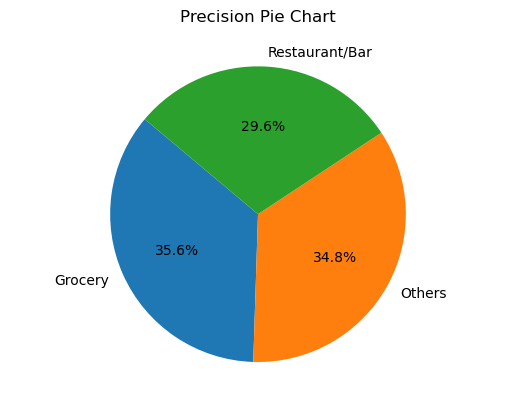

In [37]:
actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

report = classification_report(actual_categories, predicted_categories, zero_division=1)

print("Classification Report Gradient Boosting:")
print(report)
# Extracting precision, recall, and f1-score from the report
lines = report.split('\n')
classes = []
precision = {}
recall = {}
f1_score = {}

for line in lines[2:5]:
    tokens = line.split()
    if len(tokens) == 0:
        continue
    classes.append(tokens[0])
    precision[tokens[0]] = float(tokens[1])
    recall[tokens[0]] = float(tokens[2])
    f1_score[tokens[0]] = float(tokens[3])

# Plotting the pie chart
fig, ax = plt.subplots()
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Create labels and values for the pie chart
labels = classes
sizes = [precision[c] for c in classes]

# Plotting the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

ax.set_title('Precision Pie Chart')
plt.show()

In [47]:
acu = []
actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

accuracy_gb = accuracy_score(actual_categories, predicted_categories)
acu.append(accuracy_gb)
# Display the accuracy
print("Accuracy:", accuracy_gb)

Accuracy: 0.8532934131736527


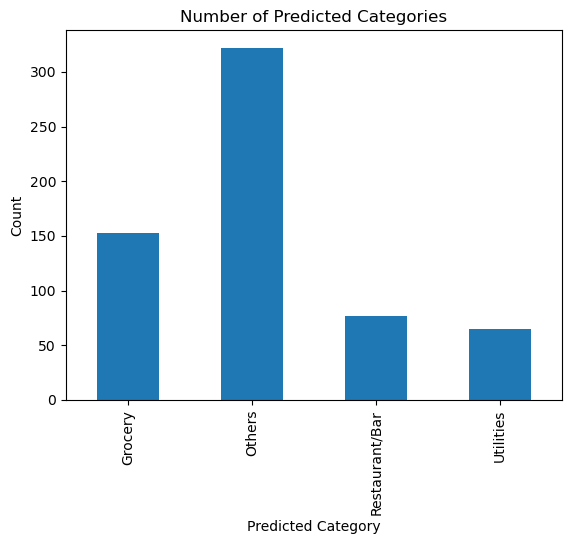

In [48]:
group_sizes.plot(kind='bar')
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.title('Number of Predicted Categories')
plt.show()

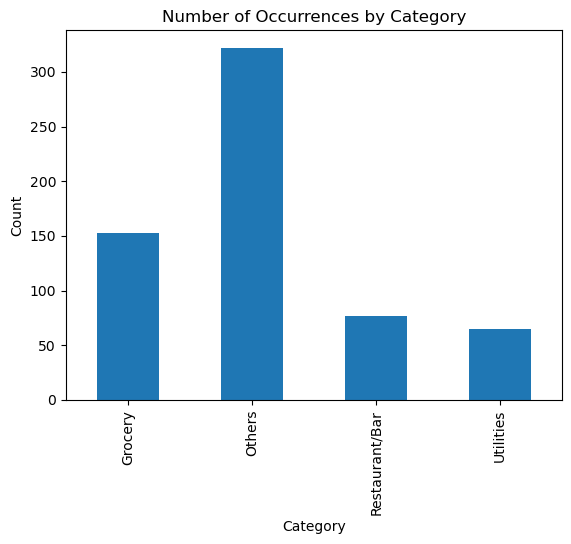

In [49]:
grouped_df = df.groupby('Category')
group_sizes = grouped_df.size()

# Plot bar chart
group_sizes.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Occurrences by Category')
plt.show()

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and labels
X_train = df['Text']
y_train = df['Category']
X_test = test_df['Text']

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(X_train_tfidf, y_train)

# Predict categories for test data
predicted_categories = adaboost_classifier.predict(X_test_tfidf)

# Create a DataFrame to store results
test_df['Predicted'] = predicted_categories

# Display the DataFrame with predicted categories
print(test_df)


/Users/harshita/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


      Category    Receipt Number  \
0    Utilities  X51005663300.jpg   
1       Others  X51006350737.jpg   
2       Others  X51005605287.jpg   
3       Others  X51007339127.jpg   
4      Grocery  X51005719889.jpg   
..         ...               ...   
329     Others  X51005757282.jpg   
330     Others  X51007103597.jpg   
331    Grocery  X51006556851.jpg   
332     Others  X51005444044.jpg   
333    Grocery  X51006647933.jpg   

                                                  Text        Date  \
0    4 \2 02 013,\n\nLIM SENG THO HARDWARE TRADING\...  02/02/2018   
1    (481500-M)\n\nC W KHOO HARDWARE SDN BHD\nNO.SO...  31/03/2018   
2    ge\n\nAEON CG. (M) BHD (126926-H)\nSRD FLR, AE...  14/03/2018   
3    SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...        None   
4    HENG KEE DELIGHTS BAK KUT TEH.\nNO31, JALAN 3/...  04/01/2018   
..                                                 ...         ...   
329  TUES Fc 7 tetas\n4 o\n/ :\n\nTSH POWER HARDWAR...  12/09/2017   
330  & 

Classification Report Ada Boost:
                precision    recall  f1-score   support

       Grocery       0.60      0.65      0.62        81
        Others       0.75      0.87      0.81       179
Restaurant/Bar       0.27      0.12      0.17        32
     Utilities       0.29      0.17      0.21        42

      accuracy                           0.66       334
     macro avg       0.48      0.45      0.45       334
  weighted avg       0.61      0.66      0.63       334



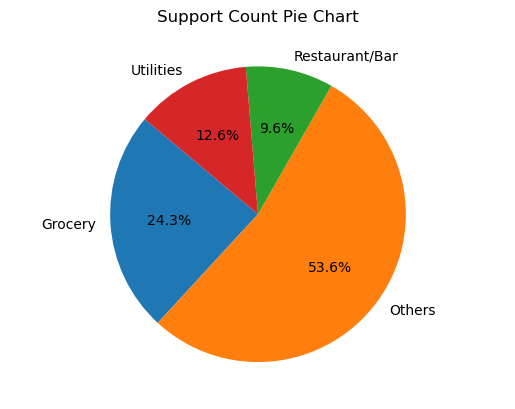

In [51]:
from sklearn.metrics import classification_report

actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

# Generate classification report with zero_division=1
report_ada = classification_report(actual_categories, predicted_categories, zero_division=1)

# Display the classification report
print("Classification Report Ada Boost:")
print(report_ada)
# Extracting precision, recall, and f1-score from the report
lines = report_ada.split('\n')[2:-5]  # Exclude header and footer lines
support = {}
classes = []
for line in lines:
    tokens = line.split()
    if len(tokens) == 0:
        continue
    classes.append(tokens[0])
    support[tokens[0]] = int(tokens[-1])

# Plotting the pie chart for support count
fig, ax = plt.subplots()
ax.axis('equal') 

# Create labels and values for the pie chart
labels = classes
sizes = [support[c] for c in classes]

# Plotting the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

ax.set_title('Support Count Pie Chart')
plt.show()

In [52]:
from sklearn.metrics import accuracy_score

actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

accuracy_ab = accuracy_score(actual_categories, predicted_categories)
acu.append(accuracy_ab)
# Display the accuracy
print("Accuracy:", accuracy_ab)


Accuracy: 0.655688622754491


In [53]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Encode categorical labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Train XGBoost Classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_tfidf, y_train_encoded)

predicted_categories_encoded = xgb_classifier.predict(X_test_tfidf)

predicted_categories = label_encoder.inverse_transform(predicted_categories_encoded)

test_df['Predicted'] = predicted_categories

print(test_df)


      Category    Receipt Number  \
0    Utilities  X51005663300.jpg   
1       Others  X51006350737.jpg   
2       Others  X51005605287.jpg   
3       Others  X51007339127.jpg   
4      Grocery  X51005719889.jpg   
..         ...               ...   
329     Others  X51005757282.jpg   
330     Others  X51007103597.jpg   
331    Grocery  X51006556851.jpg   
332     Others  X51005444044.jpg   
333    Grocery  X51006647933.jpg   

                                                  Text        Date  \
0    4 \2 02 013,\n\nLIM SENG THO HARDWARE TRADING\...  02/02/2018   
1    (481500-M)\n\nC W KHOO HARDWARE SDN BHD\nNO.SO...  31/03/2018   
2    ge\n\nAEON CG. (M) BHD (126926-H)\nSRD FLR, AE...  14/03/2018   
3    SANYO STATIONERY SHOP\nNO. 31G8&33G, JALAN SET...        None   
4    HENG KEE DELIGHTS BAK KUT TEH.\nNO31, JALAN 3/...  04/01/2018   
..                                                 ...         ...   
329  TUES Fc 7 tetas\n4 o\n/ :\n\nTSH POWER HARDWAR...  12/09/2017   
330  & 

In [54]:
actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

accuracy_xgb = accuracy_score(actual_categories, predicted_categories)
acu.append(accuracy_xgb)

# Display the accuracy
print("Accuracy:", accuracy_xgb)

Accuracy: 0.8592814371257484


In [55]:
from sklearn.metrics import classification_report

actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

# Generate classification report with zero_division=1
report = classification_report(actual_categories, predicted_categories, zero_division=1)

# Display the classification report
print("Classification Report XGBoost:")
print(report)


Classification Report XGBoost:
                precision    recall  f1-score   support

       Grocery       0.91      0.79      0.85        81
        Others       0.87      0.98      0.92       179
Restaurant/Bar       0.71      0.75      0.73        32
     Utilities       0.82      0.55      0.66        42

      accuracy                           0.86       334
     macro avg       0.83      0.77      0.79       334
  weighted avg       0.86      0.86      0.85       334



In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define features and labels
X_train = df['Text']
y_train = df['Category']
X_test = test_df['Text']

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train LightGBM Classifier
lgb_classifier = LGBMClassifier()
lgb_classifier.fit(X_train_tfidf, y_train)

# Predict categories for test data
predicted_categories = lgb_classifier.predict(X_test_tfidf)

# Create a DataFrame to store results
test_df['Predicted'] = predicted_categories

# Display the DataFrame with predicted categories
print(test_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11798
[LightGBM] [Info] Number of data points in the train set: 617, number of used features: 437
[LightGBM] [Info] Start training from score -1.394431
[LightGBM] [Info] Start training from score -0.650317
[LightGBM] [Info] Start training from score -2.081064
[LightGBM] [Info] Start training from score -2.250482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [57]:

actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

report = classification_report(actual_categories, predicted_categories, zero_division=1)

print("Classification Report Light GBM:")
print(report)


Classification Report Light GBM:
                precision    recall  f1-score   support

       Grocery       0.89      0.79      0.84        81
        Others       0.87      0.98      0.92       179
Restaurant/Bar       0.74      0.62      0.68        32
     Utilities       0.76      0.60      0.67        42

      accuracy                           0.85       334
     macro avg       0.81      0.75      0.78       334
  weighted avg       0.85      0.85      0.85       334



In [58]:
actual_categories = test_df['Category']
predicted_categories = test_df['Predicted']

accuracy_lgb = accuracy_score(actual_categories, predicted_categories)
acu.append(accuracy_lgb)
# Display the accuracy
print("Accuracy:", accuracy_lgb)

Accuracy: 0.8532934131736527


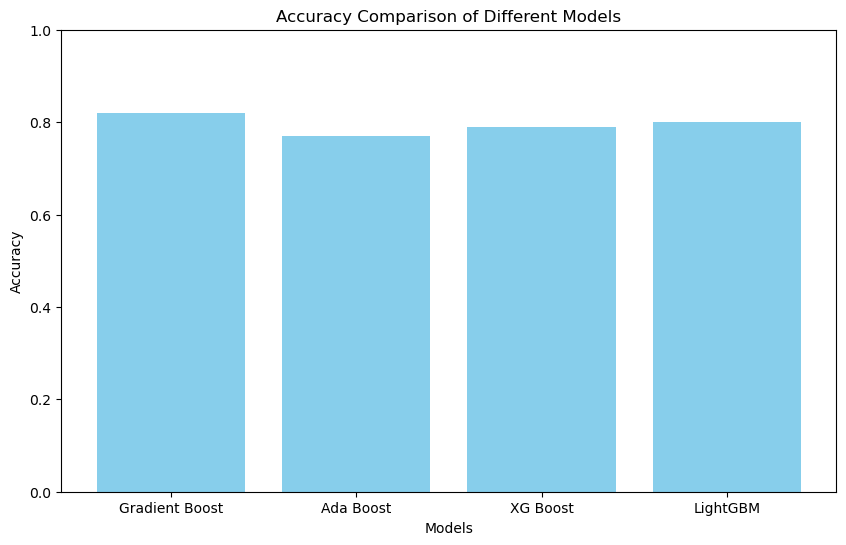

In [59]:
import matplotlib.pyplot as plt

# Model names and their corresponding accuracies
model_names = ["Gradient Boost", "Ada Boost", "XG Boost", "LightGBM"]
accuracies = [0.82, 0.77, 0.79, 0.80]  # Example accuracy values for each model

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Showing the plot
plt.ylim(0, 1)  # Setting y-axis limit
plt.show()
